In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import regex as reg
%matplotlib inline

In [2]:
!python ./Scripts/universities_extraction.py

[Info] Saved universities data to ../data/Universities.csv


Loading the data about universities:

In [3]:
universities = pd.read_csv('data/Universities.csv', index_col=0)
universities.head()

name        domain  \
0  University of Colorado at Boulder  colorado.edu   
1  University of Colorado at Boulder  colorado.edu   
2  University of Colorado at Boulder  colorado.edu   
3  Indiana University at Bloomington   indiana.edu   
4                              gmail     gmail.com   

                              mail  authorindex            file        country  
0     rebecca.swanson@colorado.edu            0  import2018_371  United States  
1  leighanna.hinojosa@colorado.edu            1  import2018_371  United States  
2       joseph.polman@colorado.edu            2  import2018_371  United States  
3             huang220@indiana.edu            0  import2018_417  United States  
4              agomoll90@gmail.com            1  import2018_417            NaN

## Base analysis of Universities present in dataset

#### What universities has the most contributors, and what percentage do they make up:

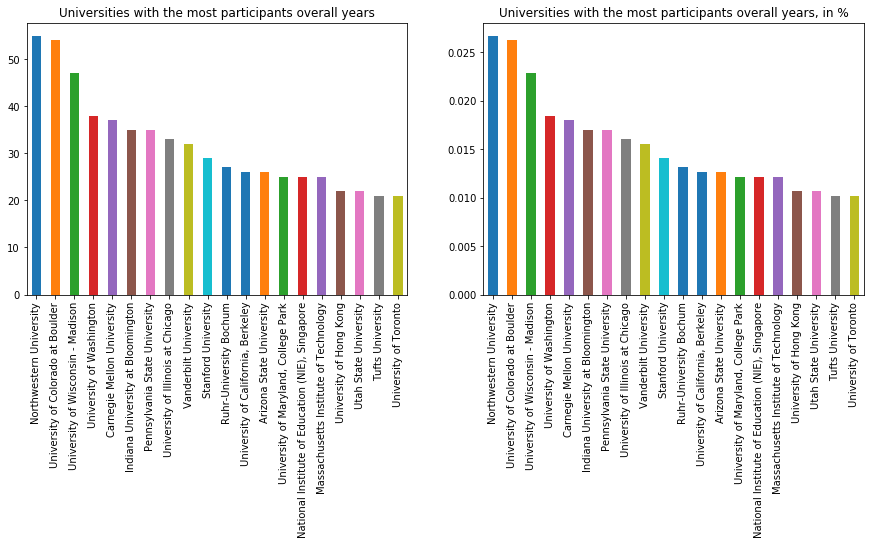

In [4]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Universities with the most participants overall years')
universities[(universities.name != 'gmail') & (~universities.mail.duplicated())].name.value_counts().head(20).plot(kind='bar')

plt.subplot(122)
plt.title('Universities with the most participants overall years, in %')
(universities[(universities.name != 'gmail')& (~universities.mail.duplicated())].name.value_counts().head(20)/universities[(~universities.mail.duplicated())].shape[0]).plot(kind='bar')
plt.show()

#### What are the countries where the most contributors are?

As determined by university affiliation

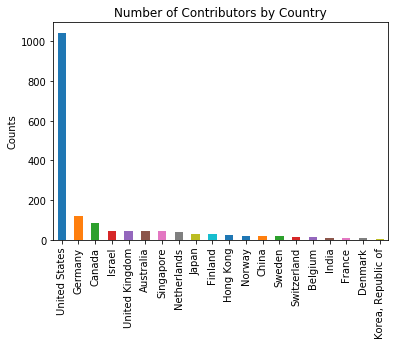

In [5]:
universities[(~universities.mail.duplicated())].country.value_counts().head(20).plot(kind = 'bar')
plt.title('Number of Contributors by Country') # as determinded by university affiliation
plt.ylabel('Counts')
plt.show()

## Considering ICLS and CSCL:

We look at which universities are present every year, only present during CSCL years and ICLS years:

In [6]:
metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0, parse_dates=['accessioned', 'available', 'issued'])
metadata.issued = metadata.issued.map(lambda x: x.year)

#dataframe with paper - author - author affiliations
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) ]

grouping =  pd.merge(metadata, universities, on='file')

In [7]:
#get universities by year
uni_year = grouping.groupby('issued').apply(lambda x: set(x['name']))

#get years in our dataset
years = uni_year.index.tolist()

#create a set of universities that have participated at some point
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

#now use odd and even years to determine universities that participated every year in either ICLS or CSCL

all_years = unis[0]
ICLS = all_
CSCL = all_
for i, x in enumerate(unis):
    all_years = all_years.intersection(x)
    
    if years[i] % 2 == 0:
        ICLS = ICLS.intersection(x)
    else:
        CSCL = CSCL.intersection(x)

We now focus on universities that participated uniquely on one or the other conference:

In [8]:
ICLS, CSCL = ICLS.difference(CSCL), CSCL.difference(ICLS)

In [9]:
print('Number of universities represeted every year: ', len(all_years))
print('Number of universities represeted at every ICLS but not CSCL: ', len(ICLS))
print('Number of universities represeted at every CSCL but not ICLS: ', len(CSCL))

Number of universities represeted every year:  37
Number of universities represeted at every ICLS but not CSCL:  57
Number of universities represeted at every CSCL but not ICLS:  12


We now look into publication counts per university over the years:

In [10]:
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) & 
                    #only consider universities that participated every year
                    (grouping.name.isin(all_years))]

ranks = pd.DataFrame(grouping.groupby('issued').name.value_counts())
ranks.columns = ['count']
ranks.reset_index(inplace=True)
ranks.head()

issued                               name  count
0    2015              University of Toronto     12
1    2015         Universität Duisburg-Essen      9
2    2015                EPFL - EPF Lausanne      8
3    2015  Indiana University at Bloomington      8
4    2015         Carnegie Mellon University      7

There seems to be some patter indicating that even amongst universities that participate every year, there is a fluctiation of numbr of papers between ICLS and CSCL

In [11]:
#we only look at universities that have at least two submissions  each year
all_ = set()
ranks[ranks['count'] > 2].groupby('issued').apply(lambda x: all_.update(set(x['name'])))

for s in ranks[ranks['count'] > 2].groupby('issued').apply(lambda x: set(x['name'])).tolist():
    all_ = all_.intersection(s)

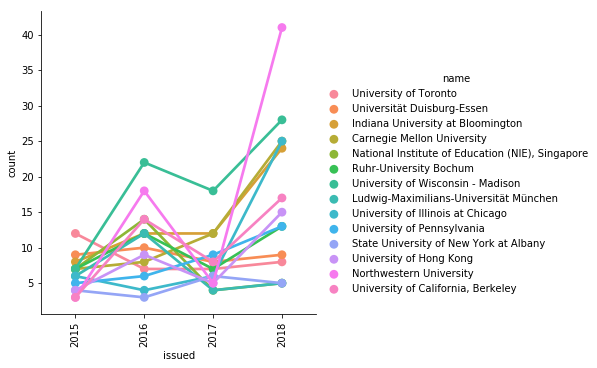

In [12]:
sns.catplot(data=ranks[ranks['name'].isin(all_) ], x='issued', y='count',kind='point', hue='name')
plt.xticks(rotation=90)
plt.show()

### Do the same thing with countries

We have an interessting result:

Increase in number of participants is mostly due to new participants from the us.

In [13]:
uni_year = grouping.groupby('issued').apply(lambda x: set(x['country']))
years = uni_year.index.tolist()
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

all_years = unis[0]
ICLS = all_
CSCL = all_


for i, x in enumerate(unis):
    all_years = all_years.intersection(x)

In [14]:
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) & 
                    #only consider universities that participated every year
                    (grouping.country.isin(all_years))]


ranks = pd.DataFrame(grouping.groupby('issued').country.value_counts())
ranks.columns = ['count']
ranks.reset_index(inplace=True)

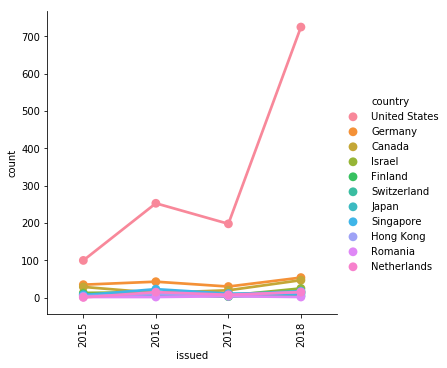

In [15]:
sns.catplot(data=ranks, x='issued', y='count',kind='point', hue='country')
plt.xticks(rotation=90)
plt.show()

Looking at it without america:

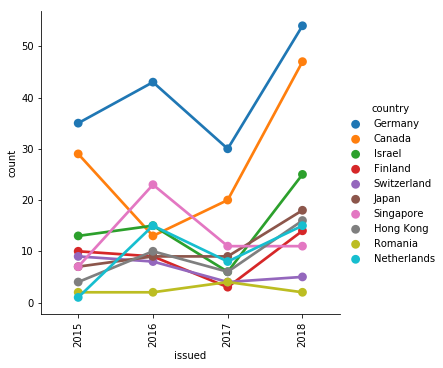

In [16]:
sns.catplot(data=ranks[(ranks.country != 'United States')], x='issued', y='count',kind='point', hue='country')
plt.xticks(rotation=90)
plt.show()

We now take an alternative view at countries, to see evolution in percentage:

In [17]:
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated())]

In [18]:
viz = pd.DataFrame(grouping[['country', 'name', 'file', 'issued']].groupby(['issued', 'country']).name.value_counts())
viz.columns = ['counts']
viz.reset_index(inplace=True)

Set a colorbar to get more readable plot:

In [19]:
country_bar = pd.DataFrame(viz.groupby(['country', 'issued']).counts.sum()/viz.groupby(['issued']).counts.sum()*100).copy()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)
to_ignore = country_bar.loc[country_bar.counts < 1].country.unique()
country_bar.loc[country_bar.country.isin(to_ignore), 'country'] = 'Other'
country_bar = country_bar.groupby(['country', 'issued']).sum()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)

country_bar.head()

country  issued     counts
0  Australia    2015   3.787879
1  Australia    2016   3.063457
2  Australia    2017   1.796407
3  Australia    2018   1.809524
4     Canada    2015  10.984848

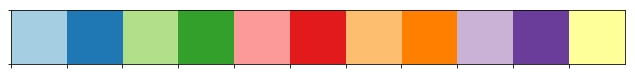

In [20]:
categories = country_bar.country.unique()
palette = sns.color_palette(palette='Paired', n_colors=len(categories)+1)

sns.palplot(palette)

We see that america makes up a bigger and bigger percentage

Text(0.5, 1.0, 'Participants by country (%)')

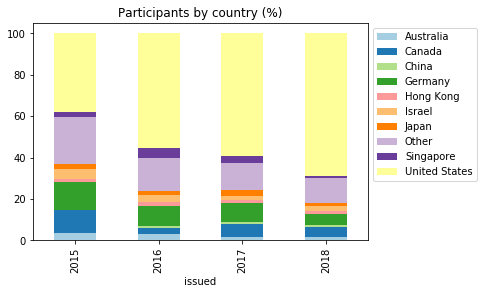

In [21]:
from matplotlib.colors import ListedColormap

country_bar = country_bar.pivot(index='issued', columns='country')
country_bar.columns = country_bar.columns.droplevel()

country_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country (%)')

In terms of absolute attendance, countries with less than 4 participants in any year are grouped into other to improve visibility:

Text(0.5, 1.0, 'Participants by country by conference')

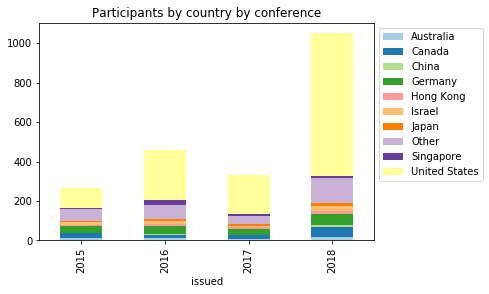

In [22]:
country_bar = pd.DataFrame(viz.groupby(['country', 'issued']).counts.sum()).copy()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)
country_bar.loc[country_bar.country.isin(to_ignore), 'country'] = 'Other'
country_bar = country_bar.groupby(['country', 'issued']).sum()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)

categories = country_bar.country.unique()
palette = sns.color_palette(palette='Paired', n_colors=len(categories)+1)

country_bar = country_bar.pivot(index='issued', columns='country')
country_bar.columns = country_bar.columns.droplevel()
country_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country by conference')

From before we know that some universities have very large increase, therefore we look at the increase in america more closely. We see that there are a lot more of authors from various universities contributing, which weren't contributing before.

Text(0.5, 1.0, 'Participants by US-university by conference')

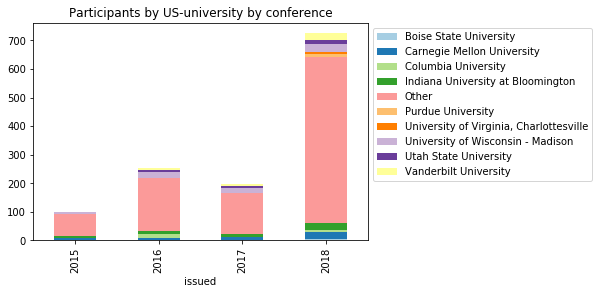

In [23]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

to_ignore = uni_bar.loc[uni_bar.counts < 6].name.unique()

uni_bar.loc[uni_bar.name.isin(to_ignore), 'name'] = 'Other'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()
uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by US-university by conference')

Text(0.5, 1.0, 'Participants by country by conference')

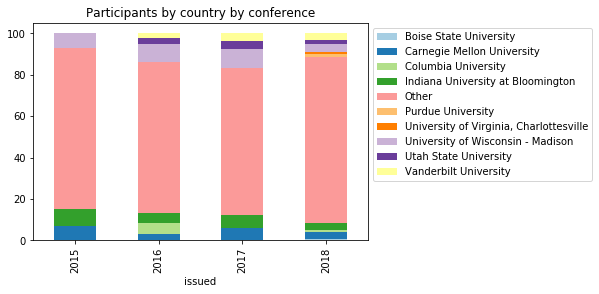

In [24]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()/uni_bar.groupby(['issued']).counts.sum()*100).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)
uni_bar.loc[uni_bar.name.isin(to_ignore), 'name'] = 'Other'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()
uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country by conference')

In [25]:
uni_bar

name    Boise State University  Carnegie Mellon University  \
issued                                                       
2015                       NaN                    7.000000   
2016                       NaN                    3.162055   
2017                       NaN                    6.060606   
2018                  0.827586                    3.448276   

name    Columbia University  Indiana University at Bloomington      Other  \
issued                                                                      
2015                    NaN                           8.000000  78.000000   
2016               5.138340                           4.743083  73.122530   
2017                    NaN                           6.060606  71.212121   
2018               0.965517                           3.310345  80.137931   

name    Purdue University  University of Virginia, Charlottesville  \
issued                                                               
2015                  NaN                                      NaN   
2016                  NaN                                      NaN   
2017                  NaN                                      NaN   
2018              1.37931                                 0.827586   

name    University of Wisconsin - Madison  Utah State University  \
issued                                                             
2015                             7.000000                    NaN   
2016                             8.695652               2.766798   
2017                             9.090909               4.040404   
2018                             3.862069               2.068966   

name    Vanderbilt University  
issued                         
2015                      NaN  
2016                 2.371542  
2017                 3.535354  
2018                 3.172414

# Looking at where people collaborate:

## Building a collaboration graph, only taking into consideration countries:

We use the author index to match up author names with indices:

In [26]:
universities['merge_index'] = universities.apply(lambda x: x['file']+str(x['authorindex']), axis=1)
metadata['merge_index'] = metadata.apply(lambda x: x['file']+str(x['author_order']), axis=1)
associations = pd.merge(universities, metadata, on='merge_index')

In [27]:
pub_collab = associations[['file_x','country', 'name']].drop_duplicates()
collabs = pd.merge(pub_collab, pub_collab, on='file_x').drop_duplicates()
collabs.dropna(inplace=True)
#collabs = collabs[collabs.country_x != collabs.country_y]
collabs.head()

file_x      country_x                             name_x  \
0  import2018_371  United States  University of Colorado at Boulder   
1  import2018_417  United States  Indiana University at Bloomington   
3  import2018_417  United States  Indiana University at Bloomington   
7  import2018_417  United States                 Indiana University   
9  import2018_417  United States                 Indiana University   

       country_y                             name_y  
0  United States  University of Colorado at Boulder  
1  United States  Indiana University at Bloomington  
3  United States                 Indiana University  
7  United States  Indiana University at Bloomington  
9  United States                 Indiana University

Building collaboration graph:

In [28]:
nodes = pd.DataFrame(collabs.country_x.dropna().unique())
nodes.columns = ['country']
nodes.reset_index(inplace=True)
nodes.head()

index         country
0      0   United States
1      1         Germany
2      2  United Kingdom
3      3          Canada
4      4           Japan

In [29]:
country_index = nodes.country.to_dict()
country_index = {v: k for k, v in country_index.items()}

collabs['index_x'] = collabs.country_x.map(country_index)
collabs['index_y'] = collabs.country_y.map(country_index)

edges = collabs[['index_x', 'index_y']].copy()

In [30]:
def get_adjacency(nodes, edges):
    n_nodes = len(nodes)
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

    for idx, row in edges.iterrows():
        i, j = int(row.index_x), int(row.index_y)
        adjacency[i, j] += 1
        adjacency[j, i] = adjacency[i, j]


    return adjacency

In [31]:
adjacency = get_adjacency(nodes, edges)

In [32]:
n_nodes = len(nodes)
graph = nx.from_numpy_array(adjacency - np.identity(n_nodes)*adjacency)
mapping = nodes.country.to_dict()

Visualizing the adjacency matrix:

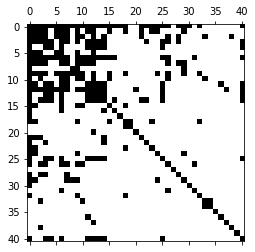

In [33]:
plt.spy(adjacency)

## Most collaborative countries

The number represented is: number of different papers written in collaboration with an other country.
Clearly, as the owerall number of papers for the us is extremly hight, the US will dominate this graph:

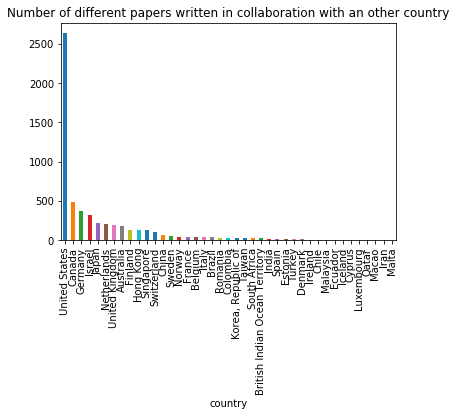

In [34]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
plt.title('Number of different papers written in collaboration with an other country')
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

What country has most collaborations with different countries?
That the number on the y axis is the number of countries the country on the x axis collaborates with: 

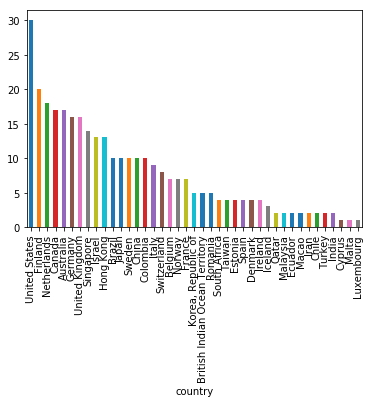

In [35]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

## Isolated Countries

In [36]:
zero_collabs = np.where((adjacency - adjacency*np.identity(n_nodes)).sum(axis=1) == 0)
nodes.iloc[zero_collabs]

index     country  degrees
27     27       Malta        1
35     35      Cyprus        1
39     39  Luxembourg        1

## Looking at the countries that do collaborate:

The total number of connected components (including isolated nodes) is:

In [37]:
nx.number_connected_components(graph)

4

Hence all other countries are part of the main component.

To more easely visualize the graph we extract the largest component and try to partition/cluster the graph in some way. Here we use the kernighan lin bisection algorithm to find a bisection. The bisection groupy the countries into countries with a lot of collaboration and little collaboration.

In [38]:
components = nx.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
graph = graph.subgraph(largest_cc)

In [39]:
#remove countries not in largest component
mapping = {k:mapping[k] for k in largest_cc if k in mapping}

In [40]:
from networkx.algorithms.community import kernighan_lin_bisection
c = list(kernighan_lin_bisection(graph))

In [41]:
def matching_by_criteria(c):
    member_label = {}
    for index, community in enumerate(c):
        members = list(community)
        for m in members:
            member_label[m] = index
    return member_label

country_partition = matching_by_criteria(c)

Change size of nodes based on with how many other countries a country interacts:

We use degree centrality, which will be large for countries with a lot of collaboration and small for countries with little collaboration.

In [42]:
node_size = (np.array(list(nx.degree_centrality(graph).values())))*2000

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


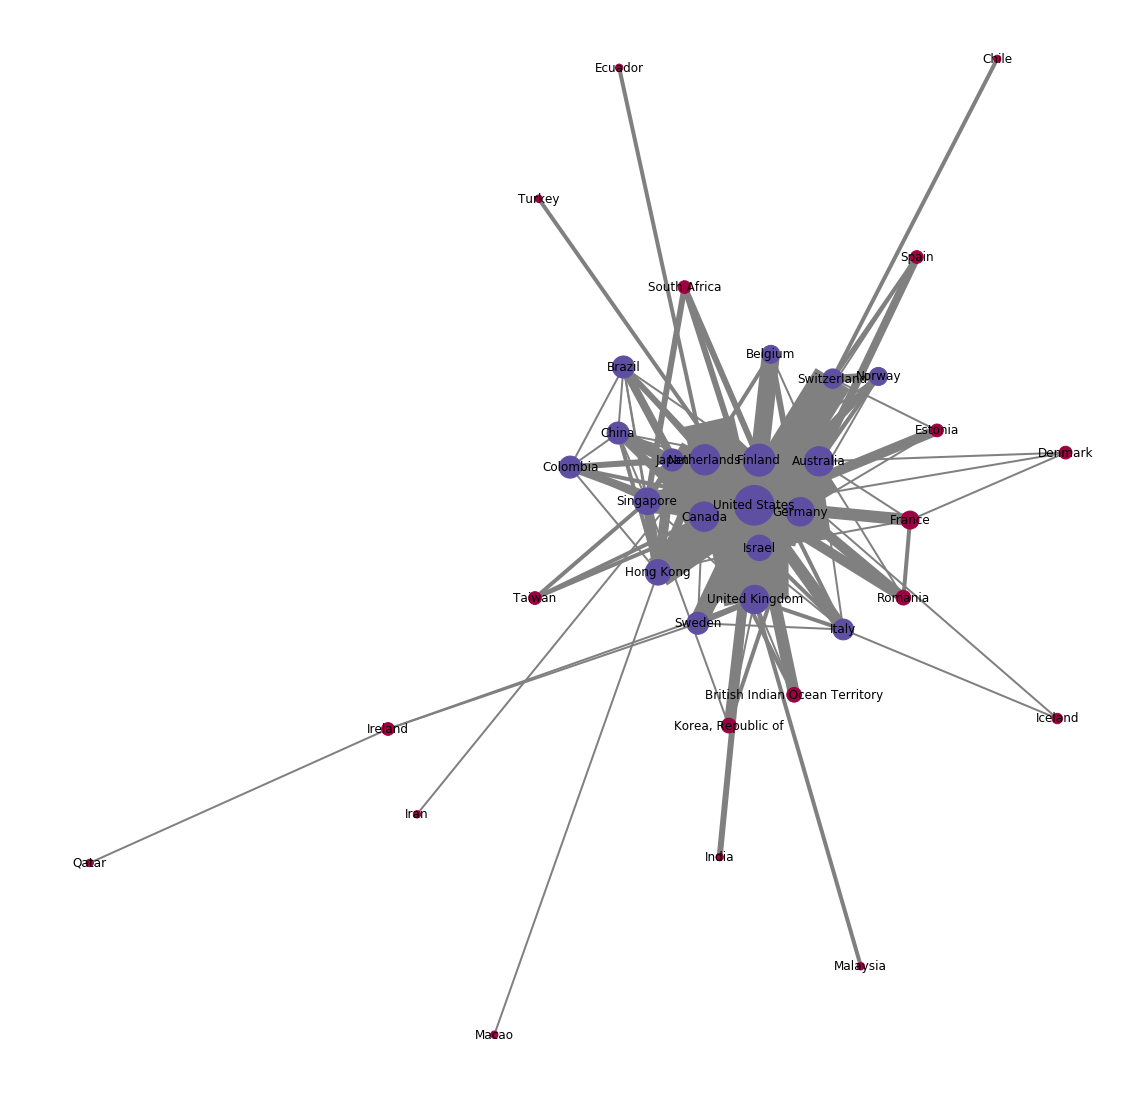

In [43]:
plt.figure(figsize=(15, 15))
nx.draw_spring(graph,  edge_color='grey', 
               node_color=pd.Series(country_partition).sort_index().tolist(), 
               width = list(nx.get_edge_attributes(graph, 'weight').values()),
               #edge_color = list(nx.get_edge_attributes(graph, 'weight').values()),
               #edge_cmap = plt.cm.gray_r,
               cmap='Spectral', 
               node_size=node_size, 
               labels=mapping)

In [44]:
edges_drawing = np.array(list(nx.get_edge_attributes(graph, 'weight').values()))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


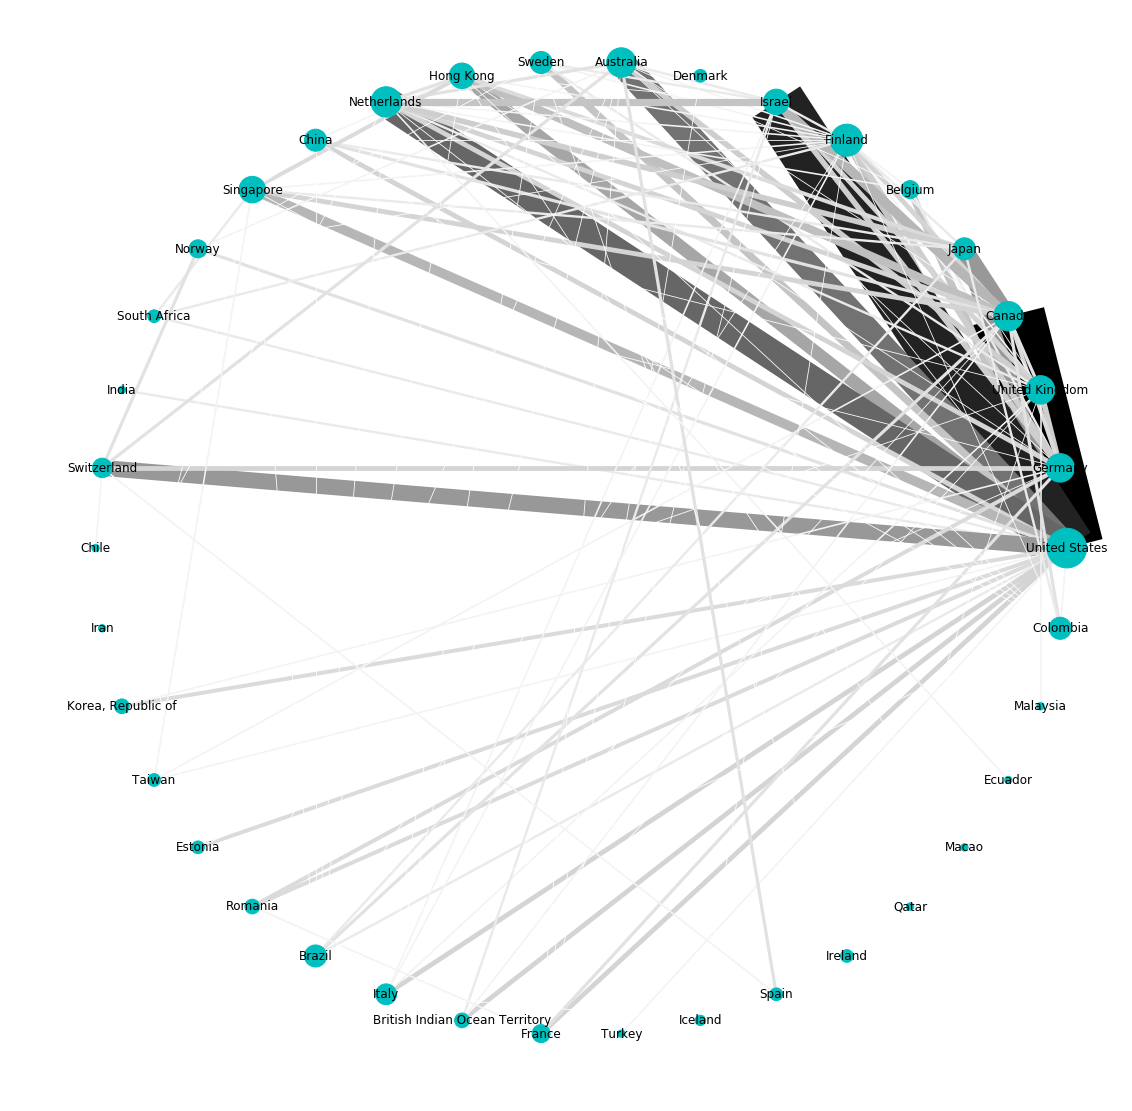

In [45]:
plt.figure(figsize=(15, 15))
nx.draw_circular(graph, 
               node_color='c', 
               width = edges_drawing/2.5,
               edge_color = np.sqrt(edges_drawing)+1,
               edge_cmap = plt.cm.gray_r,
               node_size=node_size, 
               labels=mapping)

# Do the same for university as we did for country:

Find who collaborated with whom on a paper and turn the resulting edge list into a graph:

In [46]:
pub_collab = associations[['file_x','name', 'country']].drop_duplicates()
pub_collab = pub_collab[pub_collab.name != 'gmail']
collabs = pd.merge(pub_collab, pub_collab, on='file_x').drop_duplicates()

#collabs = collabs[collabs.name_x != collabs.name_y]

nodes = pd.DataFrame(collabs.name_x.dropna().unique())
nodes.columns = ['name']
nodes.reset_index(inplace=True)

In [47]:
uni_index = nodes.name.to_dict()
uni_index = {v: k for k, v in uni_index.items()}

collabs['index_x'] = collabs.name_x.map(uni_index)
collabs['index_y'] = collabs.name_y.map(uni_index)

edges = collabs[['index_x', 'index_y']].dropna()

In [48]:
adjacency = get_adjacency(nodes, edges)
n_nodes = len(nodes)
graph = nx.from_numpy_array(adjacency - np.identity(n_nodes)*adjacency)
mapping = nodes.name.to_dict()

H=nx.relabel_nodes(graph,mapping)

### Most collaborative universities:

number of different papers written in collaboration with an other university.

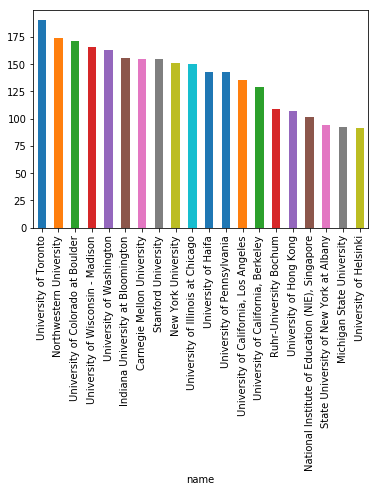

In [49]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(20).plot(kind='bar')

Number of distinct different institution collbaorations:
The number on the y axis is the number of different institutions a university collaborated with (without counting how often the did this.)

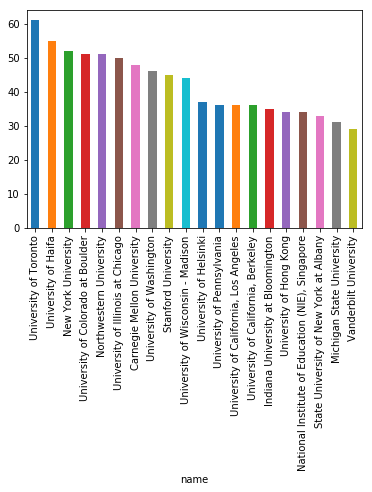

In [50]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(20).plot(kind='bar')

## Isolated universities:

Analyzing Universities that have not collaborated with other universities:

In [51]:
zero_collabs = np.where((adjacency - adjacency*np.identity(n_nodes)).sum(axis=1) == 0)
zero_collabs[0].shape

(36,)

In [52]:
nodes.iloc[zero_collabs][nodes.name.map(lambda x: True  if reg.search('\p{Lu}', x) else False)]

/anaconda3/envs/Biblio/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


index                                     name  degrees
42      42                        Aarhus University        1
70      70                      Brandeis University        1
79      79   University of Massachusetts at Amherst        1
118    118        University of Missouri - Columbia        1
119    119                Oklahoma State University        1
122    122                       Harding University        1
133    133                     Stockholm University        1
141    141                       Hanyang University        1
161    161          Georgia Institute of Technology        1
182    182              College of William and Mary        1
195    195                      University of Malta        1
227    227                  University of Groningen        1
228    228   Texas A&M University - College Station        1
256    256                      Boğaziçi University        1
273    273                University of Connecticut        1
274    274             Saint John's University (NY)        1
278    278   Korea National University of Education        1
302    302  State University of New York at Buffalo        1
315    315                    Kent State University        1
319    319                    University of Florida        1
320    320              Central Michigan University        1
321    321                         Grinnell College        1
337    337           St. Mary's College of Maryland        1
338    338                       Cardiff University        1
339    339                          Lund University        1
341    341      University of New Hampshire, Durham        1
343    343          University of Northern Colorado        1
352    352               Montclair State University        1
366    366              City University of New York        1
397    397                  Kansas State University        1

## Analyzing main group of universities interacting:

We only look at largest component and ignore universities that don't belong to the main cluster

In [53]:
components = nx.connected_components(graph)
largest_cc = max(components, key=len)

main_universities = graph.subgraph(largest_cc)

Number of components of universities that collaborate outside of main cluster:

In [54]:
nx.number_connected_components(graph) - zero_collabs[0].shape[0]-1

12

We look at the smaller connected components with at least 3 nodes:

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


272    Missouri State University
270    Illinois State University
271       Wake Forest University
Name: name, dtype: object


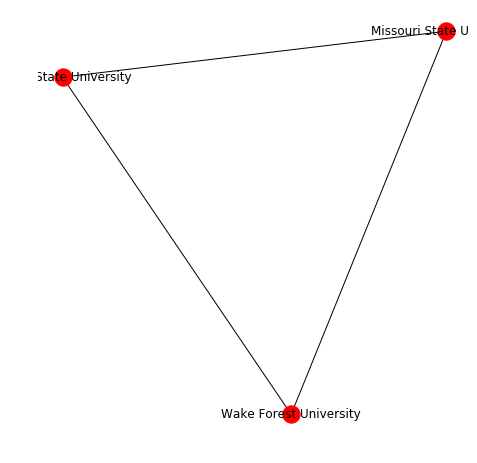

In [55]:
for g in list(nx.connected_component_subgraphs(graph)):
   
    if len(g.nodes) > 2 and len(g.nodes) < len(largest_cc):
        plt.figure(figsize=(6, 6))
        nx.draw_spring(g, labels=nodes.iloc[list(g.nodes)].name.to_dict())
        print(nodes.iloc[list(g.nodes)].name)
        plt.show()

### Main component

We partition the nodes to find "communities" of universities. They are the colored with the same color

In [56]:
from networkx.algorithms.community import greedy_modularity_communities
partition = list(greedy_modularity_communities(main_universities))
uni_partition = matching_by_criteria(partition)

Our partitioning algorthims finds 14 communities:

In [57]:
len(partition)

16

Change size of nodes based on with how many other countries a country interacts: the more connections the other nodes it has the larger the node will be.


For readability only nodes with some of the largest values –universities who are at the center of collaboration– are labeled. 

In [58]:
node_size = np.array(list(nx.degree_centrality(main_universities).values()))
edge_width = np.array(list(nx.get_edge_attributes(main_universities, 'weight').values()))

In [59]:
np.sqrt(edge_width).max()

4.242640687119285

In [60]:
nodes.loc[list(largest_cc),'node_size'] = node_size

In [61]:
labels = nodes.iloc[list(largest_cc)][nodes.node_size > np.percentile(node_size, 97.5)].name

/anaconda3/envs/Biblio/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


The color pallete for each cluster corresponds to the following cluster number:

   1  ||  2  ||  3  ||  4  ||  5  ||  6  ||  7  ||  8  ||  9  ||  10  ||  11  ||  12  ||  13  ||  14  ||  15  ||  16


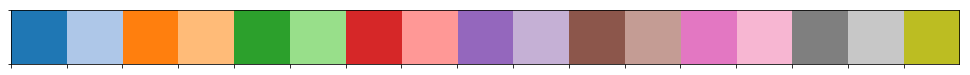

In [62]:
palette = sns.color_palette(palette='tab20', n_colors=len(partition)+1)

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(1,len(partition)+1))]))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


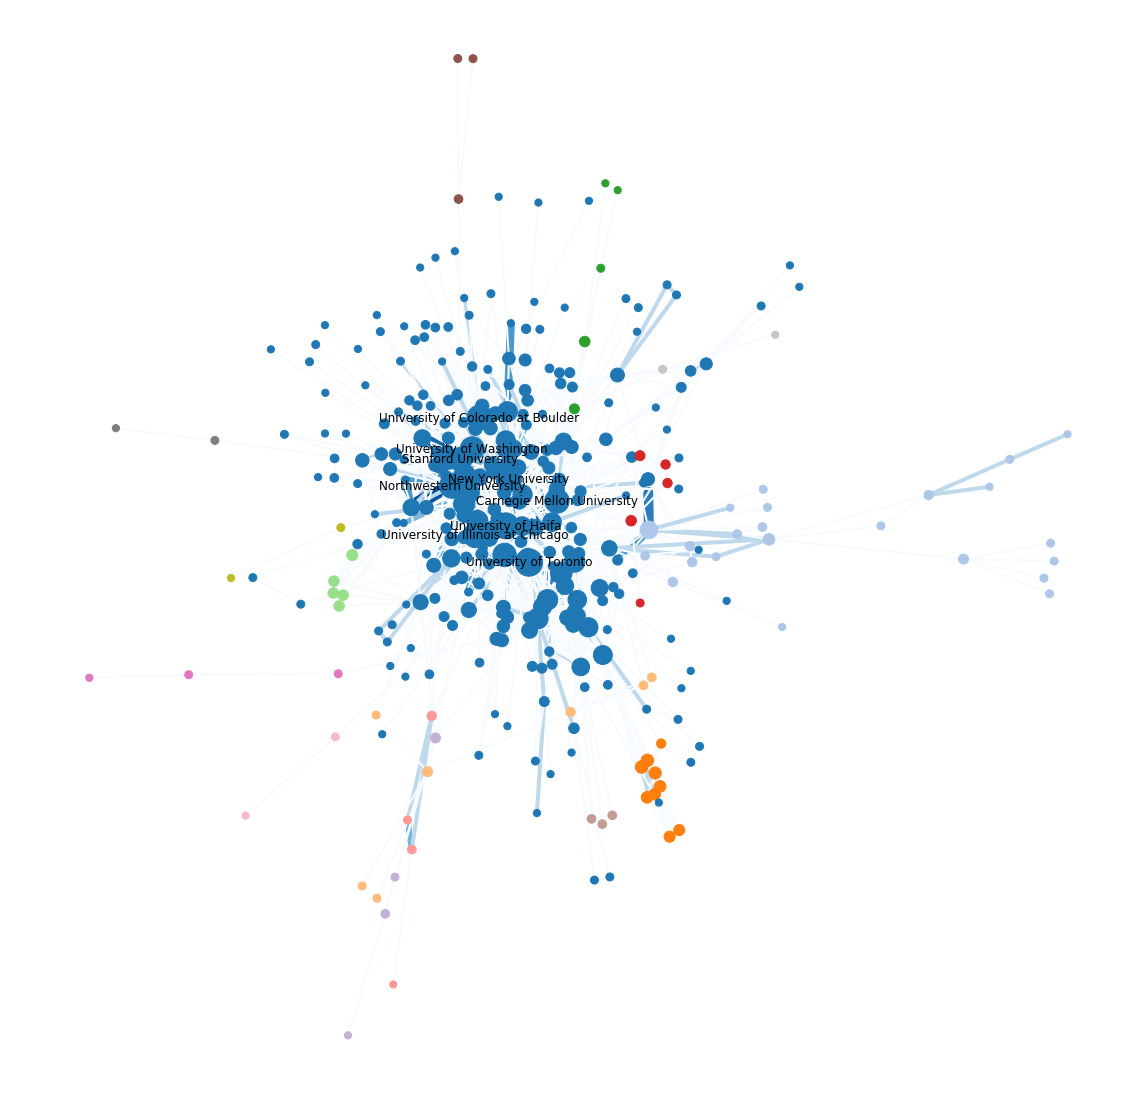

In [63]:
plt.figure(figsize=(15, 15))
nx.draw_spring(main_universities,  #edge_color='grey', 
               node_color=pd.Series(uni_partition).sort_index().tolist(),
               width = edge_width,
               edge_color = np.log(edge_width+1),
               edge_cmap = plt.cm.Blues,
               cmap=ListedColormap(palette.as_hex()), 
               node_size=(node_size+0.01)*4000, 
               labels=labels.to_dict(),
               iterations=5000
              )

The most collaboration friendly unis according to degree centrality are:

In [64]:
labels

0     University of Colorado at Boulder
18    University of Illinois at Chicago
19                University of Toronto
27                  New York University
41             University of Washington
56           Carnegie Mellon University
60                  University of Haifa
91                  Stanford University
92              Northwestern University
Name: name, dtype: object

The Universities in each cluster are:

Cluster number:  1


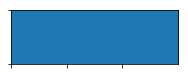

['University of Colorado at Boulder', 'Indiana University at Bloomington', 'Indiana University', 'Technische Universität München', 'Universität Augsburg', 'University of Edinburgh', 'San Jose State University', 'Harvard University', 'Vanderbilt University', 'University College London, University of London', 'University of Illinois at Chicago', 'University of Toronto', 'Tokyo University', 'Pennsylvania State University', 'New York University', 'Simon Fraser University', 'University of Jyväskylä', 'University of Wisconsin - Madison', 'Arizona State University', 'Hebrew University of Jerusalem', 'University of Texas at Austin', 'University of Maryland, College Park', 'University of California, Berkeley', 'Utah State University', 'University of Washington', 'University of Nottingham', 'Shizuoka University', 'State University of New York at Albany', 'Pädagogische Hochschule Freiburg', 'Universität Duisburg-Essen', 'University of California, Los Angeles', 'University of Pennsylvania', 'Massa

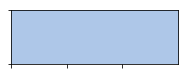

['Georgia State University', 'Virginia Commonwealth University', 'Texas State University', 'Ludwig-Maximilians-Universität München', 'University Politehnica of Bucharest', 'Mercer University', 'Ankara University', 'Walden University', 'Technical University of Cluj-Napoca', 'Middle East Technical University', 'Université Pierre Mendes-France (Grenoble II)', 'Macquarie University', 'Drexel University', 'Pohang University of Science and Technology', 'Ecole Normale Supérieure de Lyon', 'Technische Universität Darmstadt']
Cluster number:  3


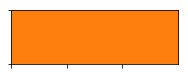

['Yokohama National University', 'Tokyo Gakugei University', 'Kobe University']
Cluster number:  4


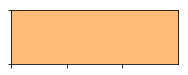

['Warren Wilson College', 'Queensland University of Technology', 'James Cook University of North Queensland', 'University of Technology Sydney', 'Open University']
Cluster number:  5


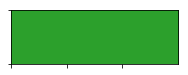

['University of Central Lancashire', 'Columbia University', 'University of Nebraska, Lincoln']
Cluster number:  6


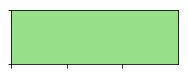

['Bauhaus Universität Weimar', 'University of Southampton', 'University of the West of England, Bristol']
Cluster number:  7


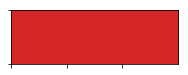

['National University of Singapore', 'Korea Advanced Institute of Science & Technology', 'Worcester Polytechnic Institute', 'University of Warwick']
Cluster number:  8


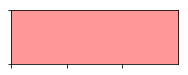

['University of Miami', 'University of Maine System', 'University of Arizona']
Cluster number:  9


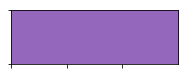

['Eberhard-Karls-Universität Tübingen', 'Universität Konstanz']
Cluster number:  12


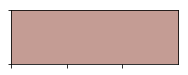

['University of Southern Denmark - SDU', 'Ohio State University, Columbus', 'University of New Mexico']
Cluster number:  13


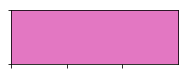

['Temple University', 'University of Delaware']
Cluster number:  14


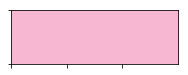

['Universität Köln', 'Rochester Institute of Technology']
Cluster number:  15


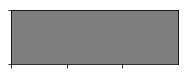

['University of California, Irvine', 'University of Chicago']
Cluster number:  16


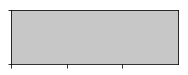

['West Virginia University', 'University of Georgia']


In [65]:
for i, m in enumerate(list(greedy_modularity_communities(main_universities))):
    unis = nodes.iloc[list(m)]
    unis = unis[unis.name.map(lambda x: True if reg.search('\p{Lu}',x) else False)].name.unique().tolist() 
    if len(unis) > 1:
        print('Cluster number: ', i+1)
        sns.palplot(palette[i])
        plt.show()
        print(unis)

# Looking at co authorship, taking into consideration country and inst.

We use the associations frame again to build a co-authorship graph based on people with attributes country and institution

In [66]:
associations.columns

Index(['name', 'domain', 'mail', 'authorindex', 'file_x', 'country',
       'merge_index', 'file_y', 'subject', 'iso', 'uri', 'type', 'publisher',
       'title', 'issued', 'accessioned', 'citation', 'available', 'abstract',
       'long_name', 'author_order', 'shortend_names', 'identifier'],
      dtype='object')

In [67]:
#we can drop one of the file columns
(associations.file_x != associations.file_y).sum()

0

In [68]:
associations['file'] = associations['file_x']
del associations['file_y'], associations['file_x']

In [69]:
associations = associations[associations.country.notna()]

In [70]:
self_merge = pd.merge(associations, associations, on='file')
self_merge = self_merge[self_merge.long_name_x != self_merge.long_name_y]

edges = self_merge[['long_name_x', 'long_name_y', 'issued_x']].copy()

nodes = associations[~associations.long_name.duplicated()].reset_index(drop=True).reset_index()

name_index = nodes.long_name.to_dict()
name_index = {v: k for k, v in name_index.items()}

In [71]:
edges['index_x'] = edges.long_name_x.map(name_index)
edges['index_y'] = edges.long_name_y.map(name_index)

adjacency = get_adjacency(nodes, edges)
graph = nx.from_numpy_array(adjacency)

Adding attributes to the graph:

In [72]:
edge_dict = {}
for i, row in edges.iterrows():
    edge_dict[(row['index_x'], row['index_y'])] =  row['issued_x']

In [73]:
nx.set_edge_attributes(graph, edge_dict, name='year')
nx.set_node_attributes(graph, nodes.country.to_dict(), name='country')
nx.set_node_attributes(graph, nodes.name.to_dict(), name='uni')
mapping = nodes.long_name.to_dict()
H=nx.relabel_nodes(graph,mapping)

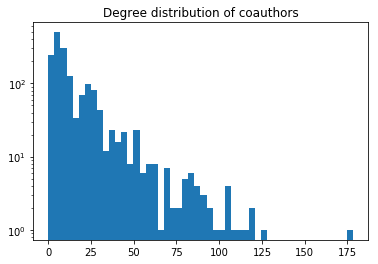

In [74]:
plt.title('Degree distribution of coauthors')
plt.hist(adjacency.sum(axis=1), bins=50, log=True)
plt.show()

This is a simple drawing of our network: we see that there is a large core communit, and many many smaller comminitues of co authors. We will look more into the main community

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


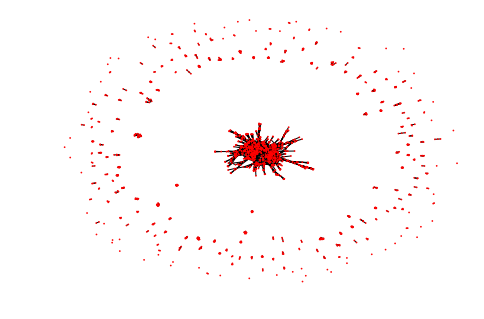

In [75]:
nx.draw(graph, pos=nx.spring_layout(graph), node_size=[0.5,0.5])

We focus in on the different components:

In [76]:
#get components
components = nx.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)

The total number of components is:

In [77]:
nx.number_connected_components(graph)

233

In [78]:
print(f'the largest component contains : {len(largest_cc)} people')

the largest component contains : 982 people


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


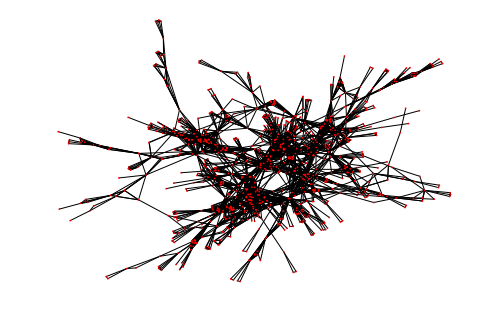

In [79]:
nx.draw(graph.subgraph(largest_cc), node_size=[0.5,0.5])

### Who colaborates the most:

We can easely find the people who worked with the most other people:
(counting repeat collaboration)

In [80]:
nodes['collabs_weighted'] = adjacency.sum(axis=1)
nodes.sort_values(by='collabs_weighted', ascending=False)[['long_name', 'country', 'name', 'collabs_weighted']].head(10)

long_name        country  \
152        Rummel, Nikol        Germany   
85        Zhang, Jianwei  United States   
377  Dillenbourg, Pierre    Switzerland   
513         Enyedy, Noel  United States   
34            Moher, Tom  United States   
932        kafai, yasmin  United States   
35      Slotta, James D.         Canada   
559          Bang, Megan  United States   
36         Acosta, Alisa         Canada   
86         Chen, Mei-Hwa  United States   

                                       name  collabs_weighted  
152                  Ruhr-University Bochum               178  
85   State University of New York at Albany               128  
377                     EPFL - EPF Lausanne               120  
513   University of California, Los Angeles               118  
34        University of Illinois at Chicago               116  
932              University of Pennsylvania               112  
35                    University of Toronto               108  
559                University of Washington               106  
36                    University of Toronto               106  
86   State University of New York at Albany               106

Same as above but counting person only once:

In [81]:
nodes['collabs_unweighted'] = np.where(adjacency > 0, 1, 0).sum(axis=1)
nodes.sort_values(by='collabs_unweighted', ascending=False)[['long_name', 'country', 'name', 'collabs_unweighted']].head(10)

long_name        country  \
152        Rummel, Nikol        Germany   
559          Bang, Megan  United States   
36         Acosta, Alisa         Canada   
85        Zhang, Jianwei  United States   
86         Chen, Mei-Hwa  United States   
833           Kali, Yael  United States   
933           Horn, Mike  United States   
513         Enyedy, Noel  United States   
34            Moher, Tom  United States   
377  Dillenbourg, Pierre    Switzerland   

                                       name  collabs_unweighted  
152                  Ruhr-University Bochum                  59  
559                University of Washington                  48  
36                    University of Toronto                  46  
85   State University of New York at Albany                  45  
86   State University of New York at Albany                  42  
833                          Boston College                  40  
933                 Northwestern University                  39  
513   University of California, Los Angeles                  38  
34        University of Illinois at Chicago                  36  
377                     EPFL - EPF Lausanne                  36

### Zooming into largest community: - country & institution

In [82]:
main_component = nodes[nodes.index.isin(largest_cc)]

Comparing the country representation in main component to the one overall.

Text(0, 0.5, 'Counts')

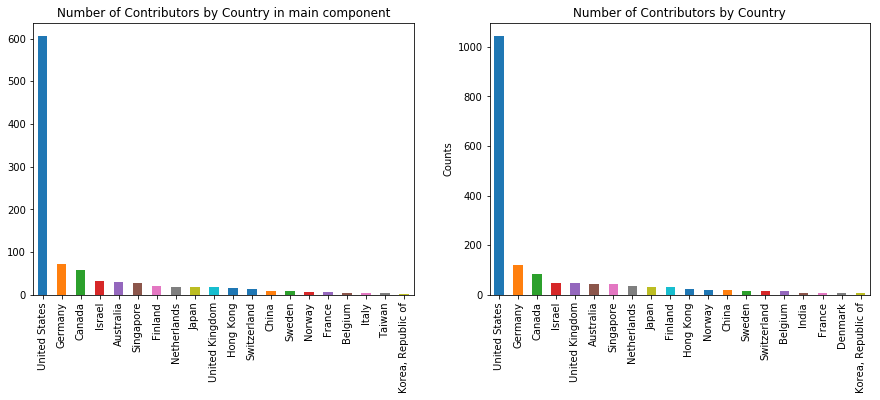

In [83]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Number of Contributors by Country in main component')
main_component.country.value_counts().head(20).plot(kind='bar')
plt.subplot(122)
universities[(~universities.mail.duplicated())].country.value_counts().head(20).plot(kind = 'bar')
plt.title('Number of Contributors by Country') # as determinded by university affiliation
plt.ylabel('Counts')

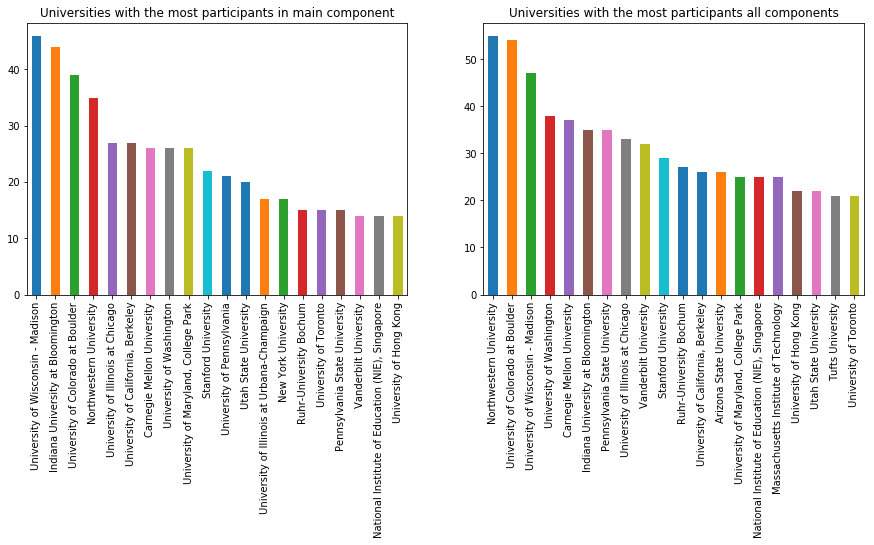

In [84]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
#plt.ylim([0, 60])
plt.title('Universities with the most participants in main component')
main_component.name.value_counts().head(20).plot(kind='bar')
plt.subplot(122)
#plt.ylim([0, 60])
plt.title('Universities with the most participants all components')
universities[(universities.name != 'gmail') & (~universities.mail.duplicated())].name.value_counts().head(20).plot(kind='bar')
plt.show()

## Finding communities in the community: Modularity and Other measures

Constructing the graph with the largest component:

In [85]:
main_component = graph.subgraph(largest_cc)
mapping = nodes.long_name.to_dict()
main_component=nx.relabel_nodes(main_component,mapping)

Here we use modularity to detect communities, which will find subgraph that are unliquely to have developed "randomly".

From wikipedia:

>It was designed to measure the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. Modularity is often used in optimization methods for detecting community structure in networks

In [86]:
c = list(greedy_modularity_communities(main_component))

We find 14 communities in total:

In [87]:
len(c)

14

In [88]:
#smallest community:
min(c, key=len)

frozenset({'Datye, Abhaya K',
           'Kittinger, Liza',
           'Qiu, Chen',
           'Svihla, Vanessa'})

## Intermezzo: removing duplicate names!

We could use this to elliminate duplicates, merge some people:

The difficulty is to not have any false positives. False negatives are fine, We thus decide to look at similar names **within** the communities we found. Additionaly we check that the same last name is present and exclude some last names (chinese ones) as they are prone to lead to false positives.

In [89]:
#example of duplicates showing up!
metadata[metadata.long_name.isin(['Cuendet, Sebastien', 'Cuendet, Sébastien'])]

file                                            subject  \
1656    import2016full_68                                                NaN   
1742   import2015full_182  ['tangible user interface', 'eye-tracking', 'j...   
1862  import2015short_182  ['tangible user interface', 'eye-tracking', 'j...   

     iso                                       uri          type  \
1656  en             info:doi/10.22318/icls2016.68  Book chapter   
1742  en  https://doi.dx.org/10.22318/cscl2015.182  Book chapter   
1862  en  https://doi.dx.org/10.22318/cscl2015.182  Book chapter   

                                              publisher  \
1656  Singapore: International Society of the Learni...   
1742   International Society of the Learning Science...   
1862   International Society of the Learning Science...   

                                                  title  issued  \
1656  Detecting Collaborative Dynamics Using Mobile ...    2016   
1742  3D Tangibles Facilitate Joint Visual Attention...    2015   
1862  3D Tangibles Facilitate Joint Visual Attention...    2015   

             accessioned                                           citation  \
1656 2017-03-21 12:05:42  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   
1742 2017-06-19 14:15:51  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   
1862 2017-06-19 14:15:51  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   

               available                                           abstract  \
1656 2017-03-21 12:05:42  Prior work has successfully described how low ...   
1742 2017-06-19 14:15:51  We report results from a dual eye-tracking stu...   
1862 2017-06-19 14:15:51  We report results from a dual eye-tracking stu...   

                long_name  author_order shortend_names  \
1656   Cuendet, Sebastien             2      Sharma K.   
1742  Cuendet, Sébastien             2      Sharma K.   
1862  Cuendet, Sébastien             2      Sharma K.   

                                             identifier           merge_index  
1656  Schneider, B., Sharma, K., Cuendet, S., Zuffer...    import2016full_682  
1742  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   import2015full_1822  
1862  Schneider, B., Sharma, K., Cuendet, S., Zuffer...  import2015short_1822

Number of members before uniformisation:

In [90]:
import difflib


def find_name_matching(c, threshold = 0.7, last_names_to_ignore = ['zhang', 'chen']):
    """finds different spellings of same name and gives mapping to create one person one name"""
    d = {}
    for community in c:
        members = list(community)
        for i, member in enumerate(members):
            for j, member_2 in enumerate(members):
                if i < j:
                    difference = difflib.SequenceMatcher(None, member, member_2).ratio()
                    if difference > threshold:
                        last_1 =reg.search('[\p{L}ä]*', member.lower()).group(0)
                        last_2 = reg.search('[\p{L}ä]*', member_2.lower()).group(0)
                        same_last_name = reg.search('[\p{L}ä]*', member.lower()).group(0) == reg.search('[\p{L}ä]*', member_2.lower()).group(0)
                        if same_last_name and last_1 not in last_names_to_ignore  and not member_2 in d.keys():
                            d[member_2] = member
    return d

d = find_name_matching(c)
len(d)

56

In [91]:
ord(u'ä')

228

In [92]:
for c in u"ä":
    print(repr(c), ord(c))

'a' 97
'̈' 776


In [93]:
#mapping unifying the different but same names
d

{'Applebaum, Lauren R.': 'Applebaum, Lauren',
 'Azevedo, Flavio S.': 'Azevedo, Flávio S.',
 'Brami, Uzi': 'Brami, Uzi Zevik',
 'Brown, David E.': 'Brown, David',
 'Champion, Dionne': 'Champion, Dionne N.',
 'Chan, Carol K. K.': 'Chan, Carol',
 'Chan, Carol K.K.': 'Chan, Carol',
 'Clegg, Tamara L.': 'Clegg, Tamara',
 'Cuendet, Sebastien': 'Cuendet, Sébastien',
 'Danish, Joshua': 'Danish, Joshua A.',
 'Dornfeld, Catherine': 'Dornfeld, Catherine L.',
 'D’Angelo, Sarah': "D'Angelo, Sarah",
 'Eagan, Brendan R.': 'Eagan, Brendan R',
 'Flood, Virginia J': 'Flood, Virginia J.',
 'Froehlich, Jon': 'Froehlich, Jon E.',
 'Gomoll, Andrea Sarah': 'Gomoll, Andrea S.',
 'Graville-Smith, Cynthia': 'Graville, Cynthia Story',
 'Halverson, Richard': 'Halverson, Erica R.',
 'Harrer, Benedikt W.': 'Harrer, Benedikt Walter',
 'Hickey, Daniel T.': 'Hickey, Daniel',
 'Hmelo-Silver, Cindy': 'Hmelo-Silver, Cindy E.',
 'Jacobson, Michael': 'Jacobson, Michael J.',
 'Kirschner, Paul': 'Kirschner, Femke',
 'Krämer

In [94]:
improved_associations = associations.copy()

In [95]:
improved_associations.loc[improved_associations.long_name.map(d).notna(), 'long_name'] = improved_associations.long_name.map(d)

In [96]:
self_merge = pd.merge(improved_associations, improved_associations, on='file')
self_merge = self_merge[self_merge.long_name_x != self_merge.long_name_y]

edges = self_merge[['long_name_x', 'long_name_y', 'issued_x']].copy()

nodes = improved_associations[~improved_associations.long_name.duplicated()].reset_index(drop=True).reset_index()

name_index = nodes.long_name.to_dict()
name_index = {v: k for k, v in name_index.items()}

edges['index_x'] = edges.long_name_x.map(name_index)
edges['index_y'] = edges.long_name_y.map(name_index)


new_graph = nx.from_numpy_array(get_adjacency(nodes, edges))


components = nx.connected_components(new_graph)
largest_cc = max(nx.connected_components(new_graph), key=len)

In [97]:
main_component = new_graph.subgraph(largest_cc)
mapping = nodes.long_name.to_dict()
#main_component=nx.relabel_nodes(main_component,mapping)

## clique detection:


Here we look at large groups of researchers that all have collaborated within eachother.
We look at groups of at least 15 people:

In [98]:
main_component_ =nx.relabel_nodes(main_component,mapping)
large_cliques = [l for l in list(nx.find_cliques(main_component_)) if len(l) > 13]

In [99]:
large_cliques[0]

['van den Ende, Joan',
 'Chen, Bodong',
 'Chan, Carol',
 'van Aalst, Jan',
 'Zhang, Jianwei',
 'Yang, Christine',
 'Matsuzawa, Yoshiaki',
 'Godinez, Erick Velazquez',
 'de Jong, Frank',
 'Rosé, Carolyn',
 'Kirschner, Femke',
 'Oshima, Jun',
 'van Heijst, Hennie',
 'Chen, Mei-Hwa',
 'Wise, Alyssa',
 'Ratté, Sylvie',
 'Chen, Feng']

We get a total of 6 groups:

In [100]:
len(large_cliques)

12

In [101]:
large_cliques = [l for l in list(nx.find_cliques(main_component)) if len(l) > 13]
color_cliques = {}
set_inclique = set()
for i, clique in enumerate(large_cliques):
    for member in clique:
        color_cliques[member] = i+1
        set_inclique.add(member)

In [102]:
for member in (set(nodes.iloc[list(largest_cc)].index.tolist())-set_inclique):
    color_cliques[member] = 0

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


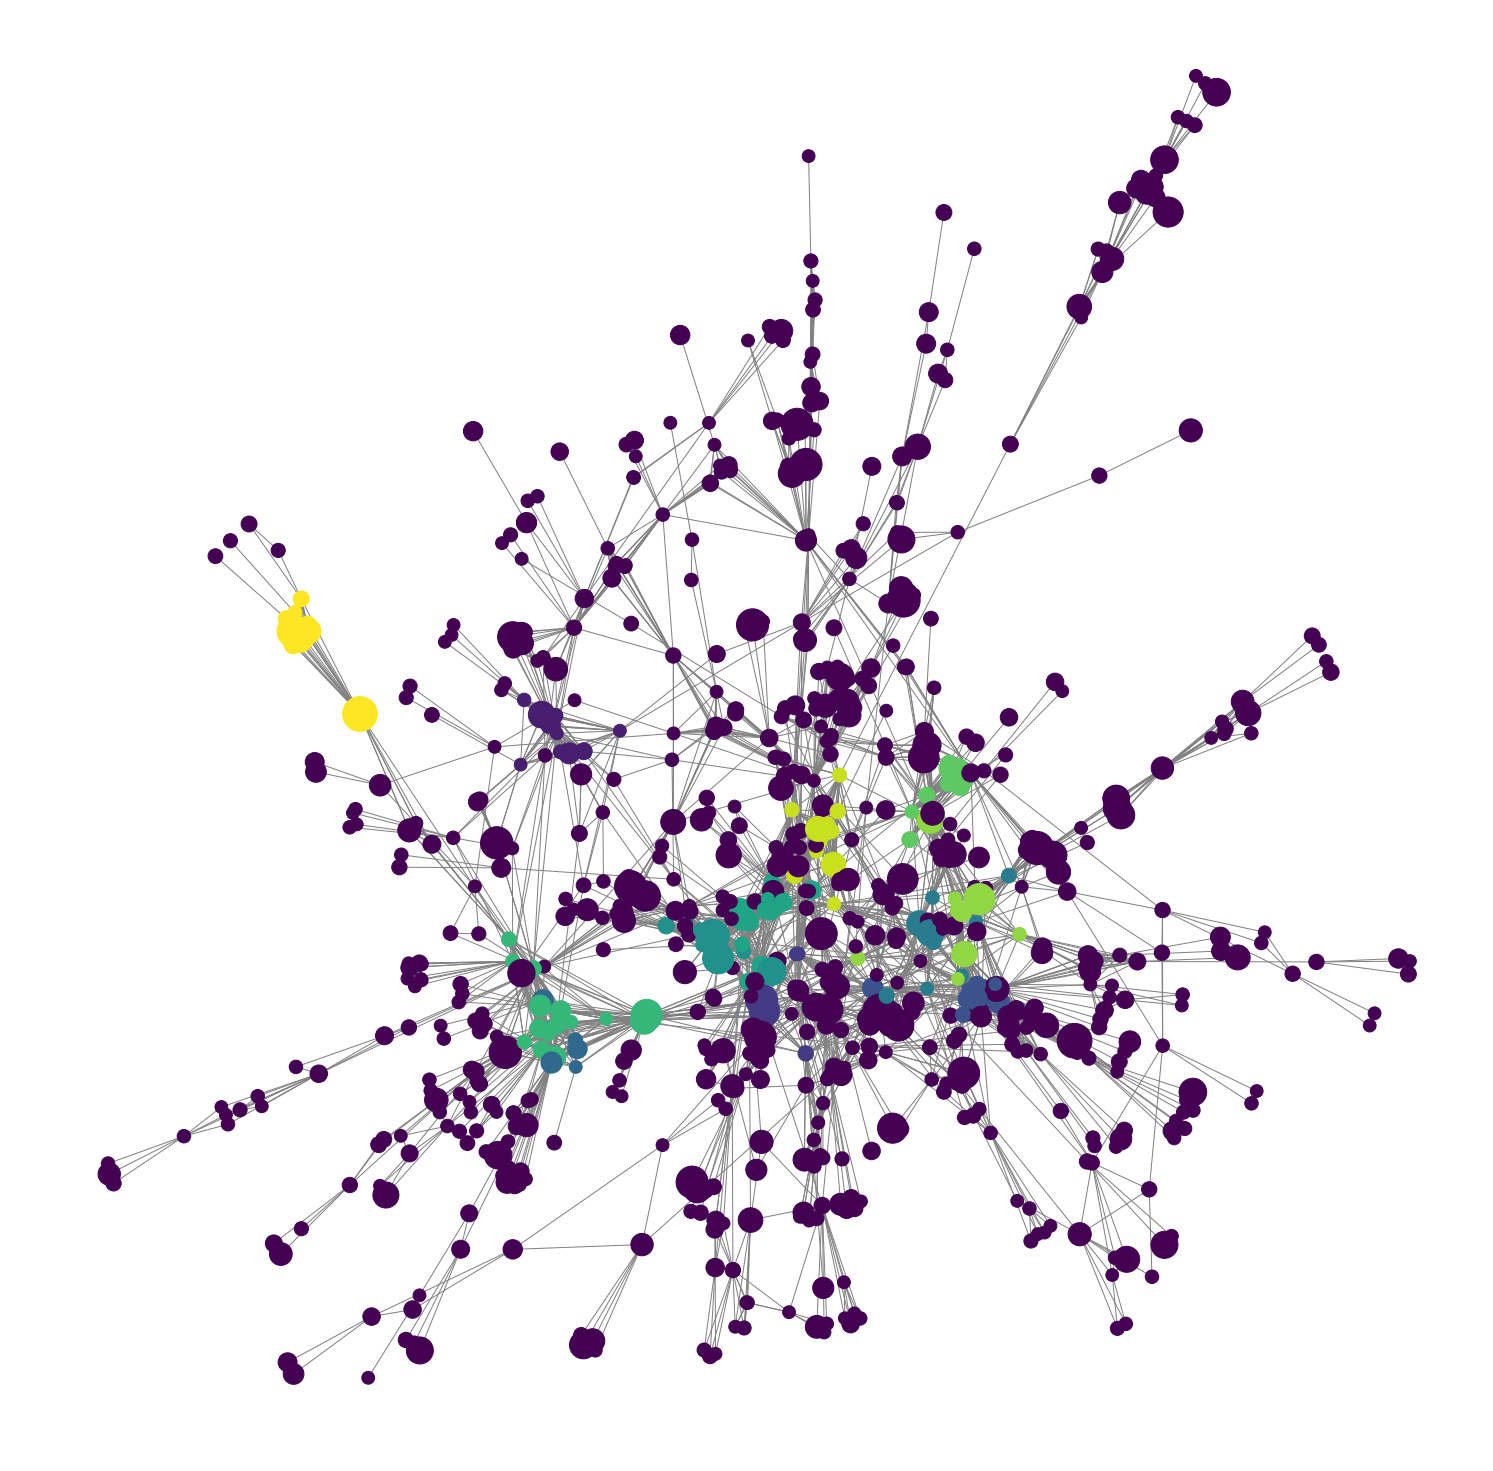

In [103]:
plt.figure(figsize=(20, 20))
nx.draw_spring(main_component, node_color=pd.Series(color_cliques).sort_index().tolist(), 
              #cmap=plt.cm.tab20c,
              node_size=(node_size+node_size.mean())*6000,
               edge_color='grey',
               iterations=400
              )

# Using modularity to identify communities:

In [104]:
mapping = nodes.long_name.to_dict()
#main_component_=nx.relabel_nodes(main_component,mapping)

c = list(greedy_modularity_communities(main_component))

In [105]:
len(c)

13

We change the node size based on degree centrality, the larger the node the more collaborations the individual has:

In [106]:
member_label = matching_by_criteria(c)
nx.set_node_attributes(main_component, member_label, 'community')
node_colors = pd.Series(member_label).sort_index().tolist()
node_size = np.array(list(nx.degree_centrality(main_component).values()))

In [107]:
node_size.mean()

0.010023933220477498

In [108]:
node_size.max()

0.061621621621621624

In [109]:
np.percentile(node_size, 95)

0.027837837837837838

We label the  nodes with the largest centrality:

In [110]:
labels = nodes.iloc[list(largest_cc)]#
labels = labels.iloc[np.where(node_size >= np.percentile(node_size, 97))].long_name.to_dict()

In [111]:
labels

{19: 'Fischer, Frank',
 34: 'Moher, Tom',
 35: 'Slotta, James',
 36: 'Acosta, Alisa',
 72: 'Bell, Philip',
 73: 'Georgen, Chris',
 82: 'Oshima, Jun',
 85: 'Zhang, Jianwei',
 86: 'Chen, Mei-Hwa',
 101: 'Danish, Joshua A.',
 145: 'Lui, Debora',
 149: 'Kafai, Yasmin',
 152: 'Rummel, Nikol',
 176: 'Matuk, Camillia',
 198: 'Clegg, Tamara',
 205: 'Linn, Marcia C.',
 254: 'Hakkarainen, Kai',
 375: 'Dillenbourg, Pierre',
 416: 'Chan, Carol',
 509: 'Enyedy, Noel',
 534: 'Rosé, Carolyn',
 543: 'Penuel, William',
 553: 'Bang, Megan',
 581: 'Humburg, Megan',
 806: 'Kidron, Adi',
 814: 'Kali, Yael',
 815: 'Tal, Tali',
 909: 'Horn, Mike'}

In [112]:
len(labels)

28

   1  ||  2  ||  3  ||  4  ||  5  ||  6  ||  7  ||  8  ||  9  ||  10  ||  11  ||  12  ||  13


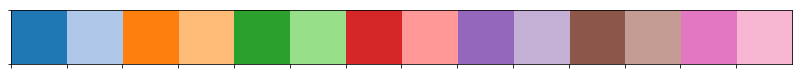

In [113]:
palette = sns.color_palette(palette='tab20', n_colors=len(c)+1)

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(1,len(c)+1))]))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


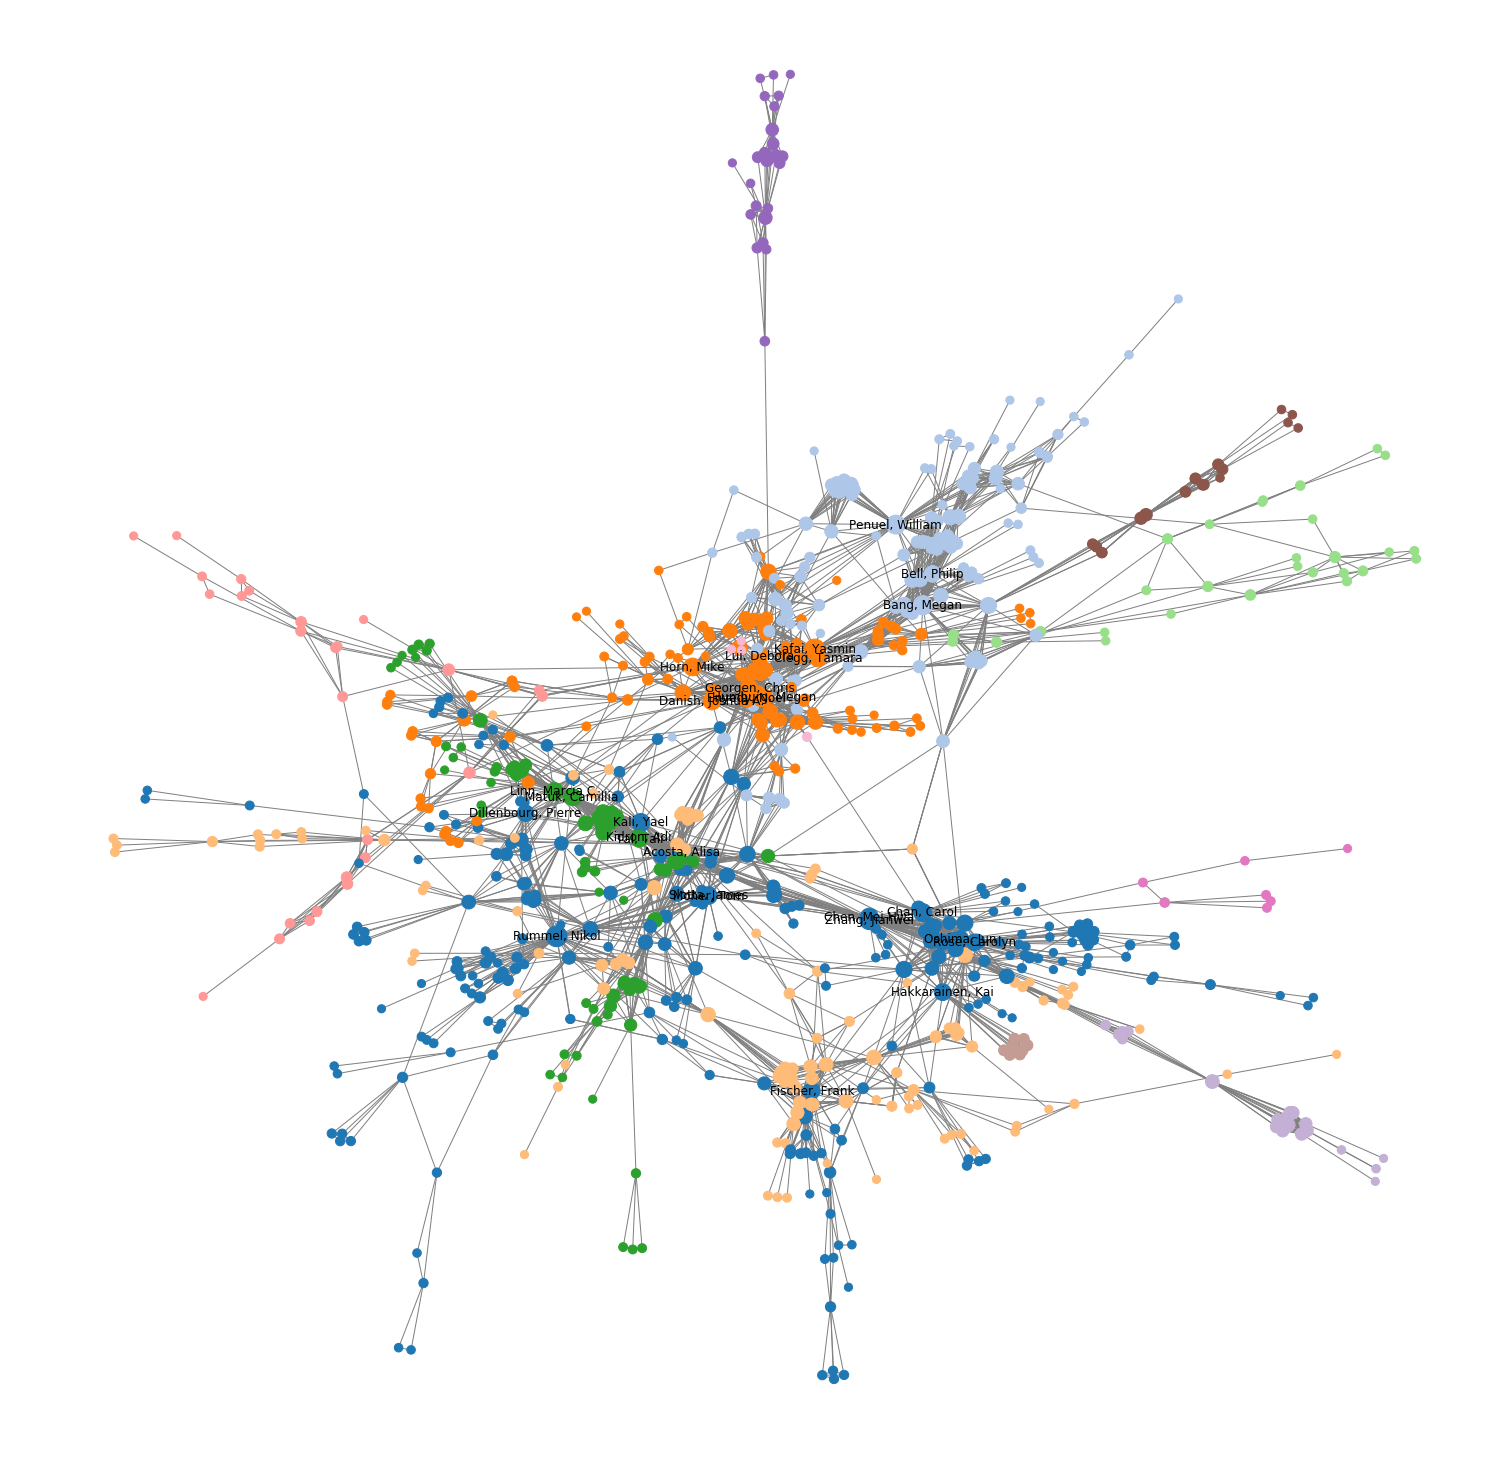

In [114]:
plt.figure(figsize=(20, 20))

nx.draw_spring(main_component, node_color=node_colors, 
                       cmap=ListedColormap(palette.as_hex()),
                       node_size=(node_size+node_size.mean())*6000,
                       labels=labels,
               edge_color='grey',
               iterations=400
              )

Here we have to code that allows to load this graph in Gephi.

In [115]:
nx.set_node_attributes(main_component, nodes.country.to_dict(), name='country')
nx.set_node_attributes(main_component, nodes.name.to_dict(), name='uni')
nx.set_node_attributes(main_component, nx.degree_centrality(graph), name='centrality')

mapping = nodes.long_name.to_dict()
main_component=nx.relabel_nodes(main_component,mapping)
#nx.write_gexf(H, 'data/main_coauthor_graph.gexf')
#nx.write_gpickle(main_component, 'data/coauthor_graph')

### Analyzing each subcomponent

We look at distribution of country and inst. inside these clusters (my it's associated members):

Cluster dist for cluster 1


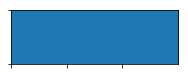

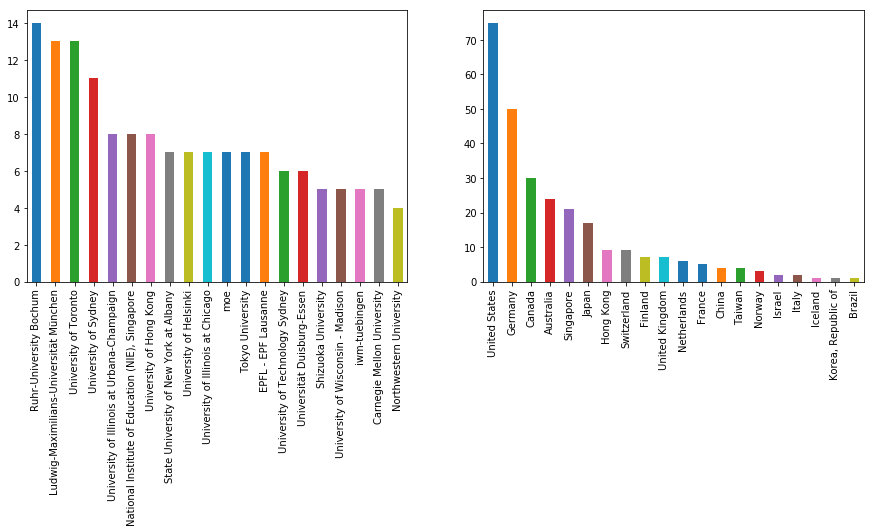

Number of countries in cluster:  25
Number of institutions in cluster:  100


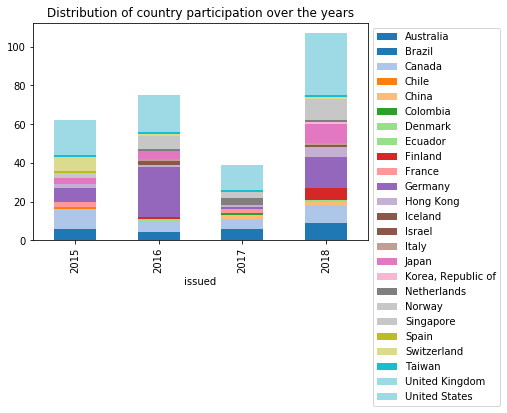

Cluster dist for cluster 2


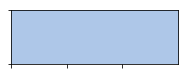

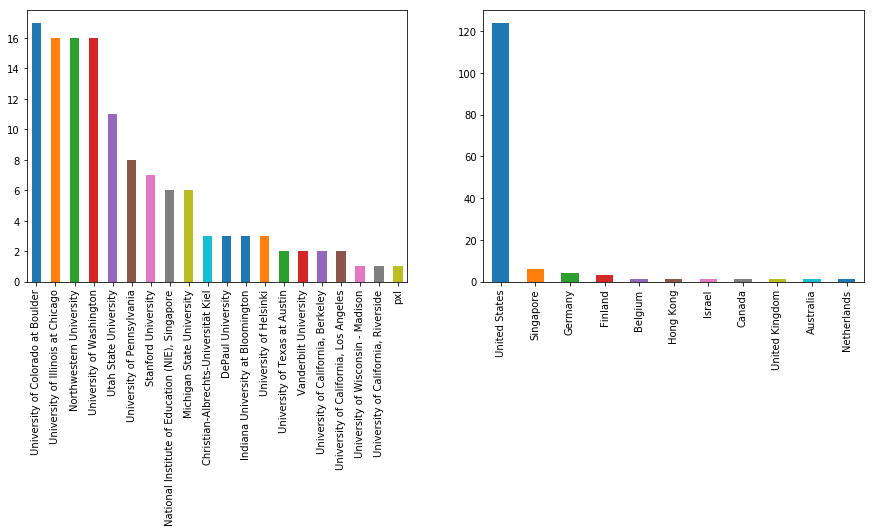

Number of countries in cluster:  11
Number of institutions in cluster:  38


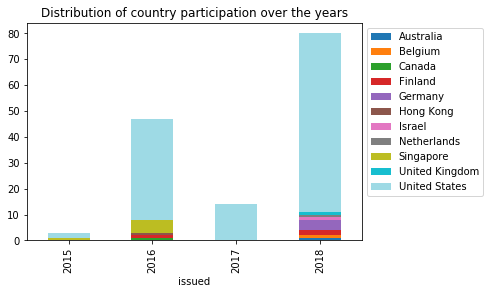

Cluster dist for cluster 3


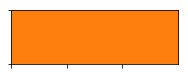

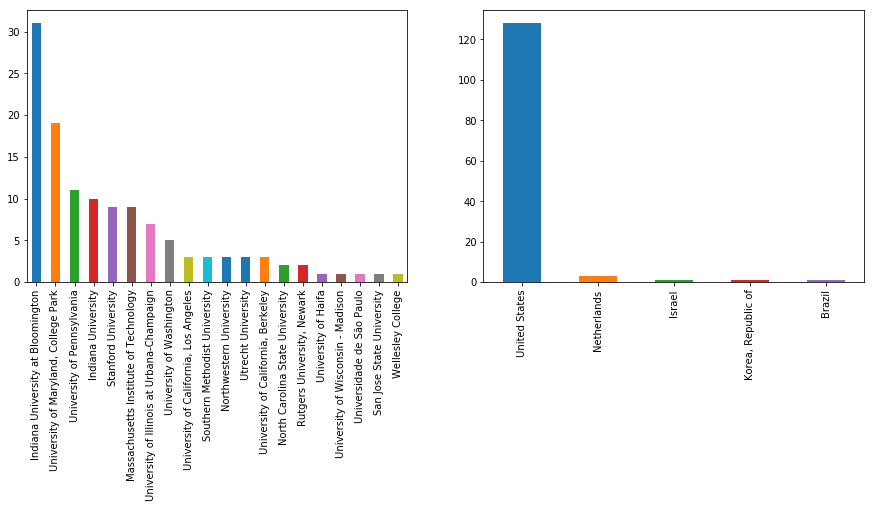

Number of countries in cluster:  5
Number of institutions in cluster:  29


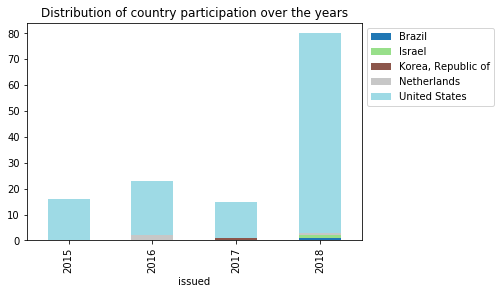

Cluster dist for cluster 4


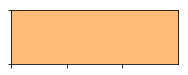

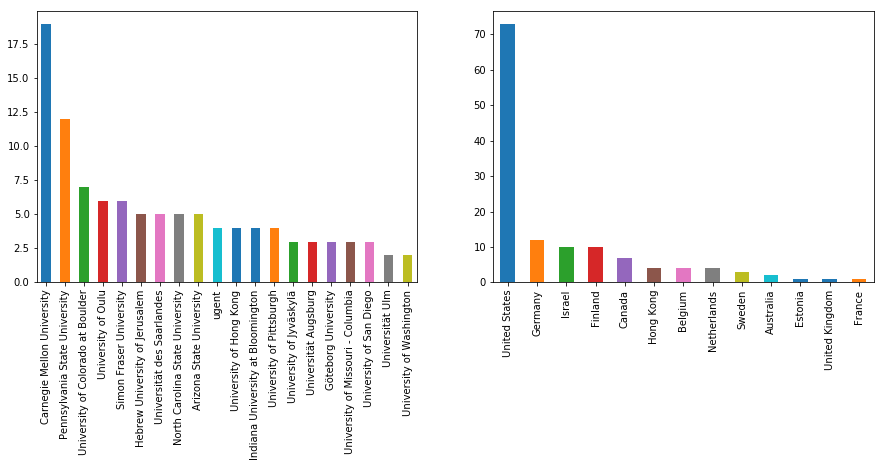

Number of countries in cluster:  13
Number of institutions in cluster:  43


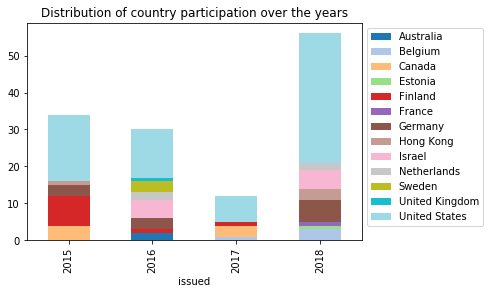

Cluster dist for cluster 5


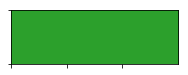

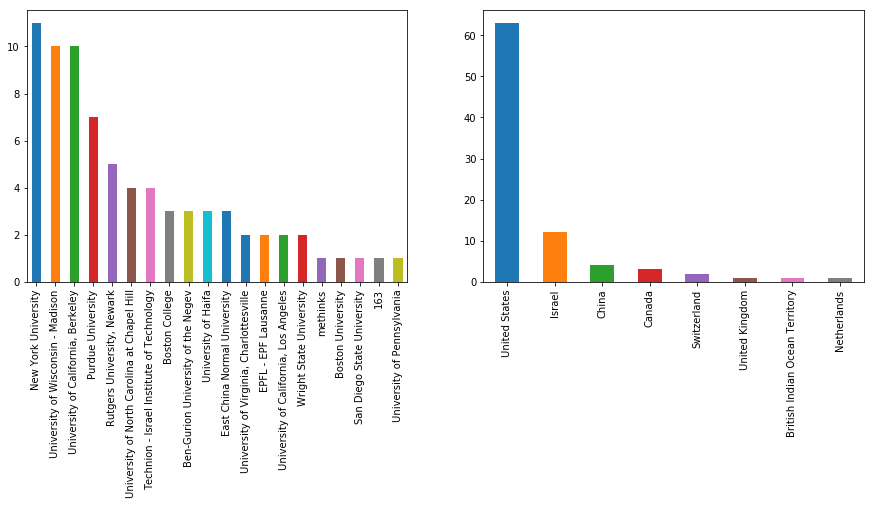

Number of countries in cluster:  8
Number of institutions in cluster:  31


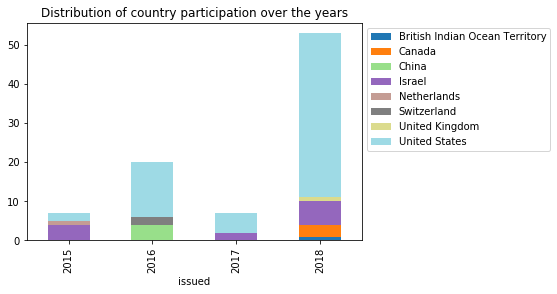

Cluster dist for cluster 6


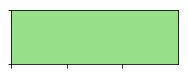

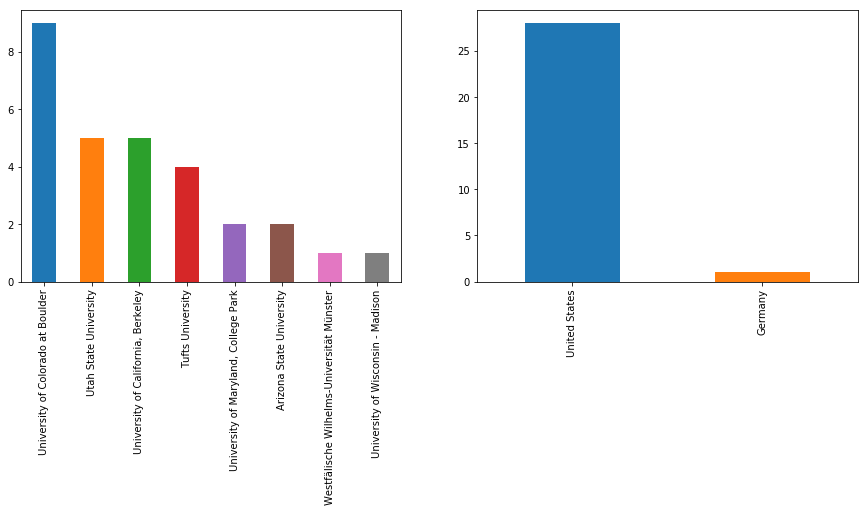

Number of countries in cluster:  2
Number of institutions in cluster:  8


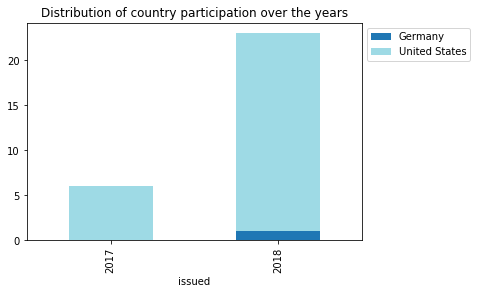

Cluster dist for cluster 7


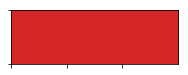

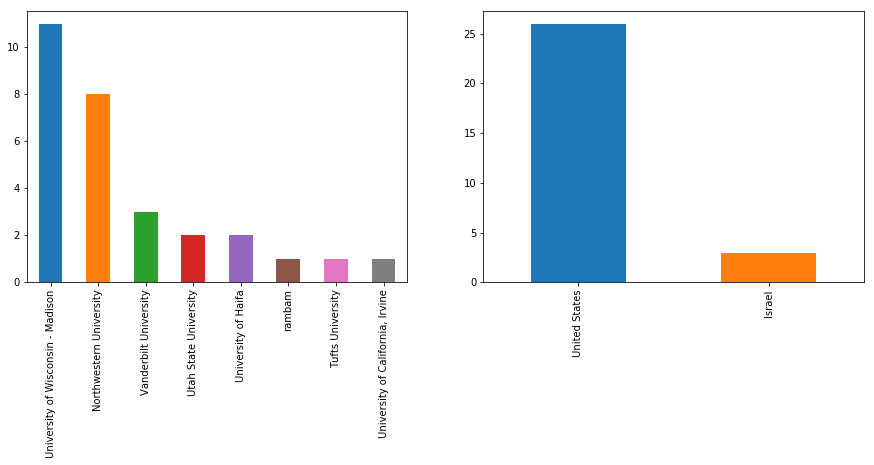

Number of countries in cluster:  2
Number of institutions in cluster:  8


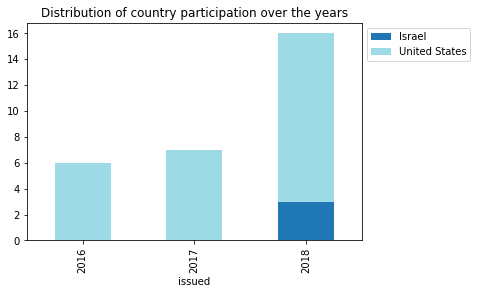

Cluster dist for cluster 8


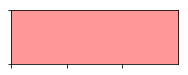

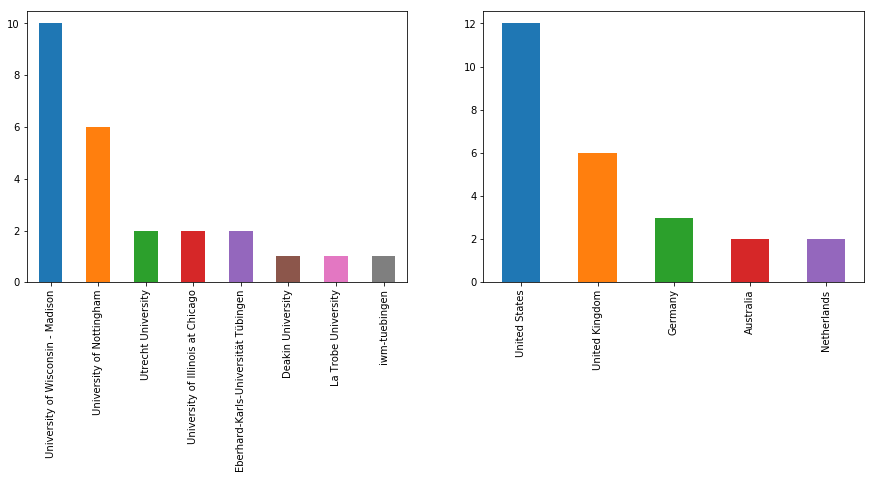

Number of countries in cluster:  5
Number of institutions in cluster:  8


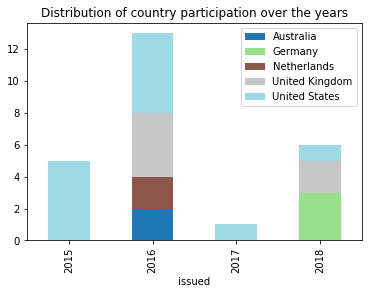

Cluster dist for cluster 9


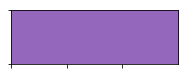

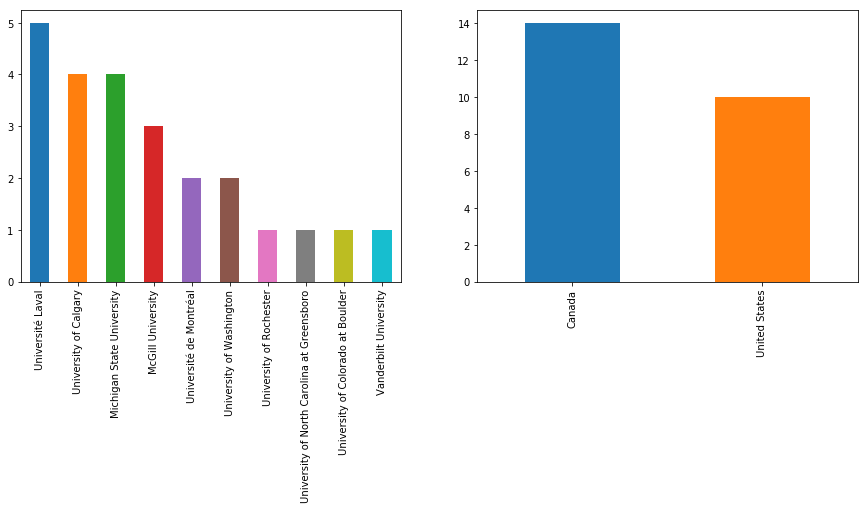

Number of countries in cluster:  2
Number of institutions in cluster:  10


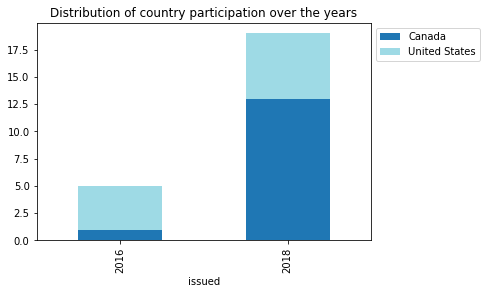

Cluster dist for cluster 10


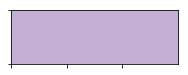

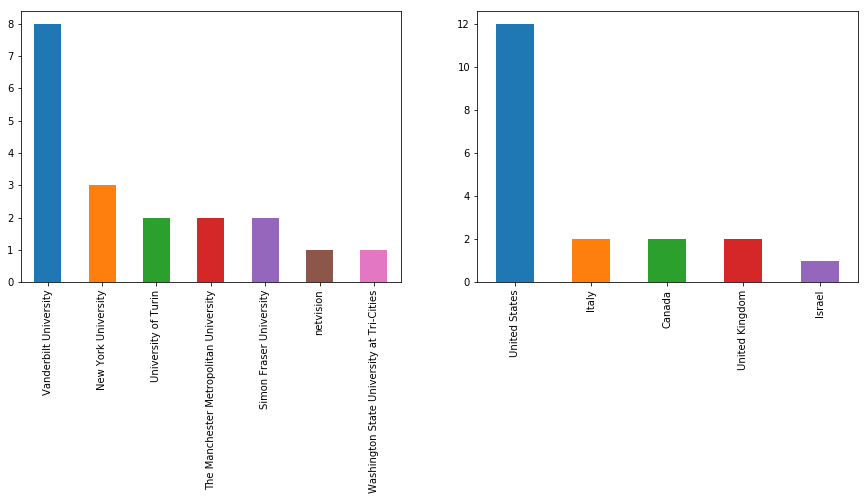

Number of countries in cluster:  5
Number of institutions in cluster:  7


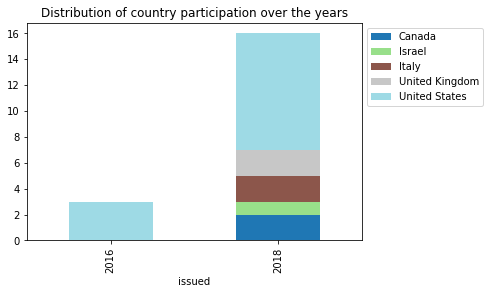

Cluster dist for cluster 11


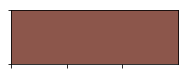

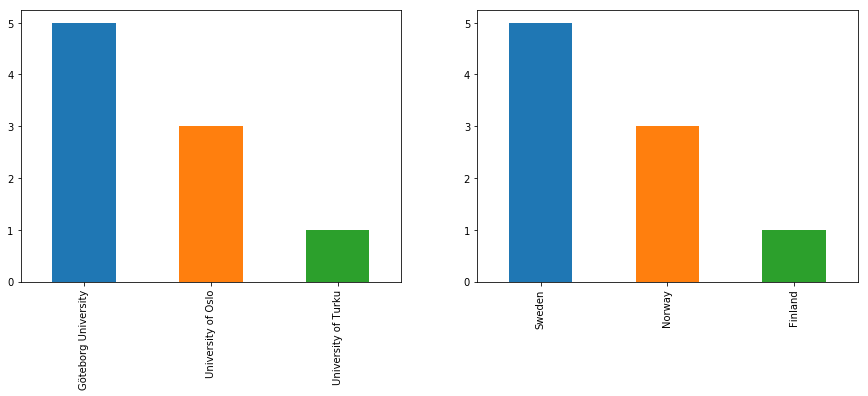

Number of countries in cluster:  3
Number of institutions in cluster:  3


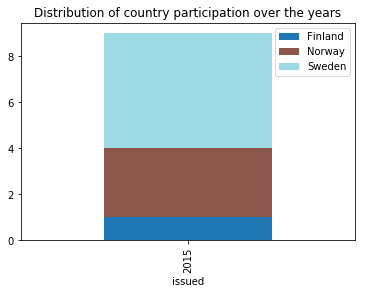

Cluster dist for cluster 12


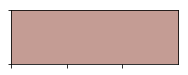

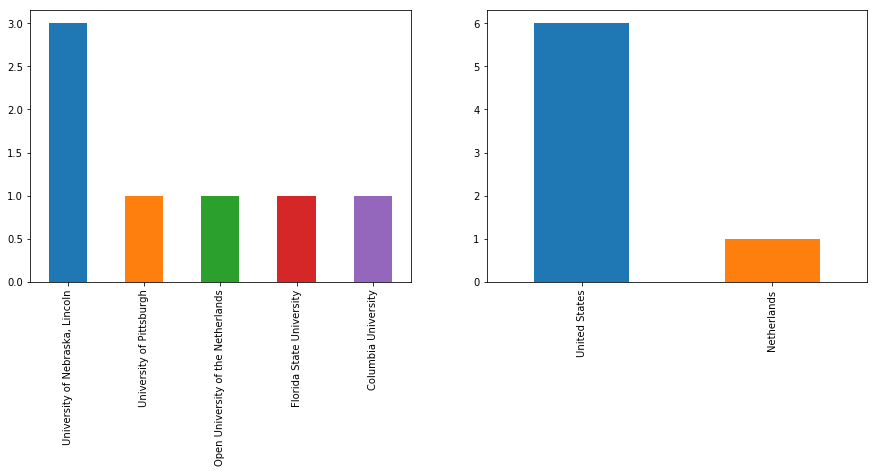

Number of countries in cluster:  2
Number of institutions in cluster:  5


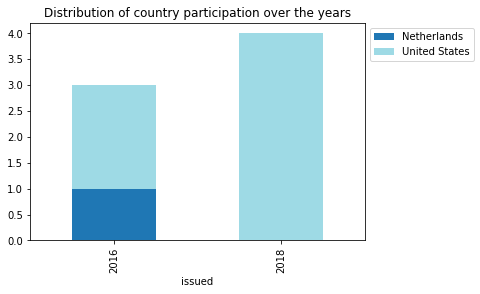

Cluster dist for cluster 13


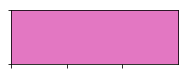

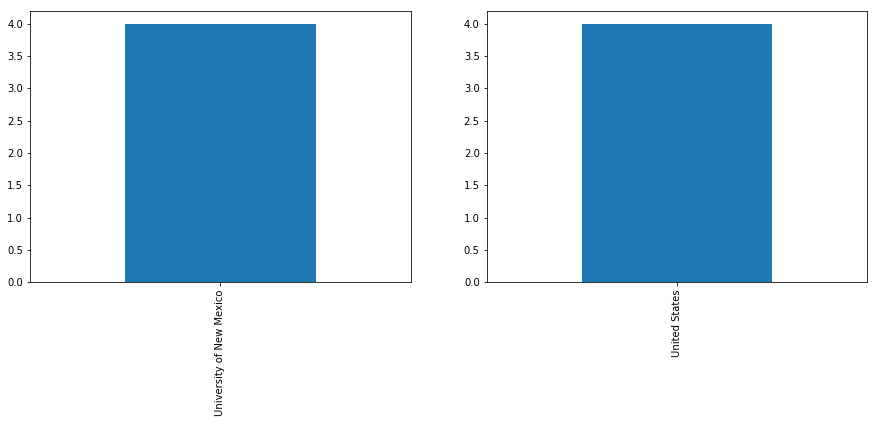

Number of countries in cluster:  1
Number of institutions in cluster:  1


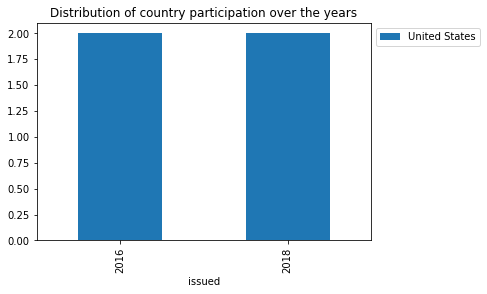

In [116]:
for i,cluster in enumerate(c):
    print(f'Cluster dist for cluster {i+1}')
    sns.palplot(palette[i])
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    nodes.iloc[list(cluster)].name.value_counts().head(20).plot('bar')
    plt.subplot(122)
    nodes.iloc[list(cluster)].country.value_counts().head(20).plot('bar')
    plt.show()
    print('Number of countries in cluster: ', len(nodes.iloc[list(cluster)].country.unique()))
    print('Number of institutions in cluster: ', len(nodes.iloc[list(cluster)].name.unique()))
    
    #plt.title('Number of people submitting over the years over the years')
    
   
    plot_df = pd.DataFrame(nodes.iloc[list(cluster)].groupby(['issued'])\
                           .country.value_counts()).rename(columns={'country':'count'}).reset_index()
    plot_df.pivot(index='issued', columns='country', values='count').plot(kind='bar', stacked=True, colormap=plt.cm.tab20)
    plt.title('Distribution of country participation over the years')
    plt.legend(bbox_to_anchor=(1, 1))
    
    plt.show()    

## An other way to partition the graph: Hierarchical clustering

## Looking at people moving around

We now look at people who moved from one country to an other within the period of the papers in the parsed papers:

We have to look at years as well to avoid duplicates, however, this could be due to people being associated to multiple institutions at once.

In [117]:
name_country = associations[['name', 'mail', 'country', 'long_name', 'shortend_names','issued']]

In [118]:
#Add year to see
df = pd.merge(name_country, name_country, on='long_name').dropna()
df = df[df.country_x != df.country_y]
df['set_countries'] = df.apply(lambda x: ''.join(sorted([x.country_x, x.country_y, str(x.issued_x), str(x.issued_y)])), axis=1)
df[~df[['long_name', 'set_countries']].duplicated()].head()

name_x                    mail_x country_x  \
455  University of Toronto    jim.slotta@utoronto.ca    Canada   
462  University of Toronto    jim.slotta@utoronto.ca    Canada   
501  University of Toronto  alisa.acosta@utoronto.ca    Canada   
507  University of Toronto  alisa.acosta@utoronto.ca    Canada   
513  University of Toronto  alisa.acosta@utoronto.ca    Canada   

            long_name shortend_names_x  issued_x               name_y  \
455  Slotta, James D.     Slotta J. D.      2015       Boston College   
462  Slotta, James D.          Kali Y.      2016       Boston College   
501     Acosta, Alisa     Slotta J. D.      2015  New York University   
507     Acosta, Alisa    Charles E. S.      2016  New York University   
513     Acosta, Alisa        Acosta A.      2018  New York University   

             mail_y      country_y shortend_names_y  issued_y  \
455   slotta@bc.edu  United States     Slotta J. D.      2017   
462   slotta@bc.edu  United States     Slotta J. D.      2017   
501  th1425@nyu.edu  United States            Clark      2018   
507  th1425@nyu.edu  United States            Clark      2018   
513  th1425@nyu.edu  United States            Clark      2018   

                   set_countries  
455  20152017CanadaUnited States  
462  20162017CanadaUnited States  
501  20152018CanadaUnited States  
507  20162018CanadaUnited States  
513  20182018CanadaUnited States

In [119]:
df = pd.merge(name_country, name_country, on='long_name').dropna()
df['set_countries'] = df.apply(lambda x: ''.join(sorted([x.name_x, x.name_y, str(x.issued_x), str(x.issued_y)])), axis=1)
df = df[~df[['long_name', 'set_countries']].duplicated()]
df[(df.name_x != df.name_y) & (df.country_x != df.country_y)][['long_name','shortend_names_y', 'name_x', 'name_y', 'issued_x', 'issued_y']].head()

long_name shortend_names_y                 name_x  \
455  Slotta, James D.     Slotta J. D.  University of Toronto   
462  Slotta, James D.     Slotta J. D.  University of Toronto   
501     Acosta, Alisa            Clark  University of Toronto   
507     Acosta, Alisa            Clark  University of Toronto   
513     Acosta, Alisa            Clark  University of Toronto   

                  name_y  issued_x  issued_y  
455       Boston College      2015      2017  
462       Boston College      2016      2017  
501  New York University      2015      2018  
507  New York University      2016      2018  
513  New York University      2018      2018

Number of people that changed organisation:

#TODO fix years

In [120]:
df[(df.name_x != df.name_y) & (df.country_x == df.country_y)].drop_duplicates().head()

name_x                            mail_x country_x  \
139  Universität Augsburg  ingo.kollar@phil.uni-augsburg.de   Germany   
140  Universität Augsburg  ingo.kollar@phil.uni-augsburg.de   Germany   
149  Universität Augsburg  ingo.kollar@phil.uni-augsburg.de   Germany   
150  Universität Augsburg  ingo.kollar@phil.uni-augsburg.de   Germany   
189  Universität Augsburg  ingo.kollar@phil.uni-augsburg.de   Germany   

        long_name shortend_names_x  issued_x  \
139  Kollar, Ingo        Kollar I.      2016   
140  Kollar, Ingo        Kollar I.      2016   
149  Kollar, Ingo        Kollar I.      2018   
150  Kollar, Ingo        Kollar I.      2018   
189  Kollar, Ingo       Shaffer D.      2017   

                                     name_y                       mail_y  \
139  Ludwig-Maximilians-Universität München       ingo.kollar@psy.lmu.de   
140  Ludwig-Maximilians-Universität München  christian.ghanem@psy.lmu.de   
149  Ludwig-Maximilians-Universität München       ingo.kollar@psy.lmu.de   
150  Ludwig-Maximilians-Universität München  christian.ghanem@psy.lmu.de   
189  Ludwig-Maximilians-Universität München       ingo.kollar@psy.lmu.de   

    country_y shortend_names_y  issued_y  \
139   Germany        Kollar I.      2015   
140   Germany       Flekova L.      2016   
149   Germany        Kollar I.      2015   
150   Germany       Flekova L.      2016   
189   Germany        Kollar I.      2015   

                                         set_countries  
139  20152016Ludwig-Maximilians-Universität München...  
140  20162016Ludwig-Maximilians-Universität München...  
149  20152018Ludwig-Maximilians-Universität München...  
150  20162018Ludwig-Maximilians-Universität München...  
189  20152017Ludwig-Maximilians-Universität München...

## Plotting edges by year:

In [121]:
collab_years = edges[~edges[['index_x', 'index_y']].duplicated()]
collab_years = collab_years[collab_years.apply(
    lambda x: (x['index_x'], x['index_y']) in list(main_component.edges()), axis=1)]

In [122]:
collab_years.shape, edges.shape, len(list(main_component.edges()))

((0, 5), (12296, 5), 4293)

In [123]:
years_edge = {}
for i, row in collab_years.iterrows():
    years_edge[(row.index_x, row.index_y)] = row.issued_x

   2015  ||  2016  ||  2017  ||  2018


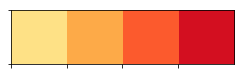

In [124]:
palette = sns.color_palette(palette='YlOrRd', n_colors=4)

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(2015, 2019))]))